# 🔬 Multi-Model Comparison Analysis for Tourism Mobility Prediction

*Automated analysis and visualization for comparing multiple LLM models with dual prompt strategies on VeronaCard dataset*

---

## 🎯 Obiettivi del Notebook

Questo notebook fornisce un **framework completo** per confrontare le performance di diversi modelli LLM con **due strategie di prompt** sulla predizione next-POI turistici:

- **📊 Strategia Base**: Prompt senza informazioni geometriche  
- **🌍 Strategia Geometrica**: Prompt con informazioni spaziali integrate

Genera automaticamente:

- **📈 Grafici comparativi affiancati** per visualizzare entrambe le strategie
- **📊 Analisi dei miglioramenti** dovuti all'informazione geometrica
- **🎨 Visualizzazioni side-by-side** pronte per inclusione nella tesi
- **📋 Report automatici** con tabelle LaTeX-ready

## 📁 Struttura Repository Attuale

**✅ CONFIGURAZIONE AUTOMATICA**: Il notebook si adatta automaticamente alla struttura esistente:

```
LLM-Mob-As-Mobility-Interpreter/
├── notebook/
│   └── multi_model_comparison_analysis.ipynb  # questo notebook
├── results/                                   # Modelli standard
│   ├── llama3.1_8b/
│   │   ├── base_version/        # CSV strategia base
│   │   └── with_geom_srv_univr/ # CSV strategia geometrica
│   ├── mixtral_8x7b/
│   │   └── base_version/        # CSV strategia base
│   ├── qwen2.5_7b/
│   │   ├── base_version/        # CSV strategia base
│   │   └── with_geom/           # CSV strategia geometrica
│   ├── qwen2.5_14b/
│   │   ├── base_version/        # CSV strategia base
│   │   └── with_geom/           # CSV strategia geometrica
│   └── DEV/                     # ⚠️ IGNORATA (file di debug)
├── results_deepseek-coder_33b_base_version/   # DeepSeek base (directory separata)
├── results_deepseek-coder_33b_with_geom/      # DeepSeek geom (directory separata)
├── results_mixtr_with_geom/                   # Mixtral geom (directory separata)
└── img/                                       # Output grafici
    └── multi_model_comparison/
        ├── base/           # Grafici solo strategia base
        ├── geom/           # Grafici solo strategia geometrica
        └── side_by_side/   # Grafici comparativi affiancati
```

## 🚀 Workflow di Utilizzo

1. **✅ Auto-detection**: Il notebook rileva automaticamente le directory disponibili
2. **🔍 Verifica dati**: Controlla che esistano file CSV in entrambe le strategie
3. **📊 Carica ed analizza**: Processa entrambe le strategie per ogni modello
4. **📈 Genera confronti**: Crea grafici affiancati e analisi miglioramenti
5. **💾 Salva output**: Esporta grafici, tabelle e codice LaTeX

## 🆕 Nuove Funzionalità Dual-Strategy

- **Grafici 2x3 affiancati**: Strategia base sopra, geometrica sotto
- **Barre sovrapposte**: Confronto diretto con frecce di miglioramento
- **Analisi delta**: Grafici dei miglioramenti percentuali
- **Radar charts**: Confronto multidimensionale per ogni modello
- **Tabelle integrate**: Base e Geom nella stessa tabella con calcolo Δ%

---

## 📦 Setup e Configurazione

### Configurazione dei modelli da analizzare
Modifica questa configurazione in base ai modelli che hai testato:

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import ast
import json
import warnings
from collections import Counter, defaultdict
import os

# Configurazione stile grafici
plt.rcParams['figure.dpi'] = 300  # Alta qualità per la tesi
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 11

# Sopprime warning non critici
warnings.filterwarnings('ignore', category=UserWarning)

print("📦 Setup completato!")
print(f"📊 Working directory: {os.getcwd()}")

📦 Setup completato!
📊 Working directory: /leonardo_work/IscrC_LLM-Mob/LLM-Mob-As-Mobility-Interpreter/notebook


### Configurazione modelli e colori

In [9]:
# ============================================================================
# CONFIGURAZIONE MODELLI - Struttura corretta basata sulla repository reale
# ============================================================================

# Configurazione basata sulla struttura reale osservata
MODELS = {
    'deepseek-coder_33b': {
        'name': 'DeepSeek-Coder 33B',
        'base_dir': '../results/deepseek-coder_33b/base_version/',  # Directory separata
        'geom_dir': '../results/deepseek-coder_33b/with_geom/',     # Directory separata
        'color': '#d62728',  # Rosso
        'params': '33B',
        'type': 'Coding'
    },
    'llama3.1_8b': {
        'name': 'LLaMA 3.1 8B',
        'base_dir': '../results/llama3.1_8b/base_version/',
        'geom_dir': '../results/llama3.1_8b/with_geom/',
        'color': '#1f77b4',  # Blu
        'params': '8B',
        'type': 'Baseline'
    },
    'mixtral_8x7b': {
        'name': 'Mixtral 8x7B',
        'base_dir': '../results/mixtral_8x7b/base_version/',
        'geom_dir': '../results/mixtral_8x7b/with_geom/',  # Directory separata per geom
        'color': '#ff7f0e',  # Arancione
        'params': '8x7B (47B active)',
        'type': 'MoE'
    },
    'qwen2.5_7b': {
        'name': 'Qwen 2.5 7B',
        'base_dir': '../results/qwen2.5_7b/base_version/',
        'geom_dir': '../results/qwen2.5_7b/with_geom/',
        'color': '#2ca02c',  # Verde
        'params': '7B',
        'type': 'Multilingual'
    },
    'qwen2.5_14b': {
        'name': 'Qwen 2.5 14B',
        'base_dir': '../results/qwen2.5_14b/base_version/',
        'geom_dir': '../results/qwen2.5_14b/with_geom/',
        'color': '#9467bd',  # Viola
        'params': '14B',
        'type': 'Multilingual-Large'
    }
}

# Directory per salvare i grafici - organizzate per strategie
OUTPUT_DIRS = {
    'comparison': '../img/multi_model_comparison/',
    'base_comparison': '../img/multi_model_comparison/base/',
    'geom_comparison': '../img/multi_model_comparison/geom/',
    'side_by_side': '../img/multi_model_comparison/side_by_side/',
    'individual': '../img/'  # + model_key per grafici specifici
}

# Crea directory se non esistono
for dir_path in OUTPUT_DIRS.values():
    Path(dir_path).mkdir(parents=True, exist_ok=True)

print("🎨 Configurazione modelli corretta per struttura repository reale:")
print("   📊 Struttura mista: alcune directory in results/, altre separate")
print("   🚫 Directory results/DEV/ IGNORATA (file di debug)")
print()

# Verifica esistenza directory e correzione automatica per DeepSeek
print("🔍 Verifica e correzione directory configurate:")

# Controllo speciale per DeepSeek che ha directory separate dalla root
deepseek_base_alt = '../results/deepseek-coder_33b_base_version/'
deepseek_geom_alt = '../results/deepseek-coder_33b_with_geom/'

if Path(deepseek_base_alt).exists():
    MODELS['deepseek-coder_33b']['base_dir'] = deepseek_base_alt
    print("✅ DeepSeek-Coder 33B: Utilizzando directory base_version separata")

if Path(deepseek_geom_alt).exists():
    MODELS['deepseek-coder_33b']['geom_dir'] = deepseek_geom_alt
    print("✅ DeepSeek-Coder 33B: Utilizzando directory with_geom separata")

# Controllo speciale per Mixtral che ha geom directory separata
mixtral_geom_alt = '../results_mixtr_with_geom/'
if Path(mixtral_geom_alt).exists():
    MODELS['mixtral_8x7b']['geom_dir'] = mixtral_geom_alt
    print("✅ Mixtral 8x7B: Utilizzando directory geom separata")

print()

# Verifica finale di tutte le directory
for key, model in MODELS.items():
    print(f"  {model['name']:>20s}:")
    
    base_exists = Path(model['base_dir']).exists()
    geom_exists = Path(model['geom_dir']).exists()
    
    print(f"    Base: {model['base_dir']} {'✅' if base_exists else '❌'}")
    print(f"    Geom: {model['geom_dir']} {'✅' if geom_exists else '❌'}")
    
    if base_exists:
        base_files = list(Path(model['base_dir']).glob('*_pred_*.csv'))
        print(f"          └─ {len(base_files)} file CSV base")
    
    if geom_exists:
        geom_files = list(Path(model['geom_dir']).glob('*_pred_*.csv'))
        print(f"          └─ {len(geom_files)} file CSV geom")

print(f"\n📁 Output directories create:")
for name, path in OUTPUT_DIRS.items():
    print(f"  {name}: {path}")

🎨 Configurazione modelli corretta per struttura repository reale:
   📊 Struttura mista: alcune directory in results/, altre separate
   🚫 Directory results/DEV/ IGNORATA (file di debug)

🔍 Verifica e correzione directory configurate:

    DeepSeek-Coder 33B:
    Base: ../results/deepseek-coder_33b/base_version/ ✅
    Geom: ../results/deepseek-coder_33b/with_geom/ ✅
          └─ 12 file CSV base
          └─ 12 file CSV geom
          LLaMA 3.1 8B:
    Base: ../results/llama3.1_8b/base_version/ ✅
    Geom: ../results/llama3.1_8b/with_geom/ ✅
          └─ 14 file CSV base
          └─ 12 file CSV geom
          Mixtral 8x7B:
    Base: ../results/mixtral_8x7b/base_version/ ✅
    Geom: ../results/mixtral_8x7b/with_geom/ ✅
          └─ 12 file CSV base
          └─ 12 file CSV geom
           Qwen 2.5 7B:
    Base: ../results/qwen2.5_7b/base_version/ ✅
    Geom: ../results/qwen2.5_7b/with_geom/ ✅
          └─ 12 file CSV base
          └─ 12 file CSV geom
          Qwen 2.5 14B:
    Base: .

## 📈 1. Caricamento e Preprocessing Dati

### Funzioni di utilità per il caricamento dati

In [10]:
def poi_id(x):
    """
    Normalizza identificatori POI per confronti consistenti.
    Gestisce dict, liste, e stringhe/numeri.
    """
    if isinstance(x, dict):
        for key in ('poi', 'poi_id', 'name', 'id'):
            if key in x:
                return str(x[key])
        return json.dumps(x, sort_keys=True)
    elif isinstance(x, (list, tuple)):
        return tuple(map(poi_id, x))
    else:
        return str(x)

def load_model_data(model_dir, model_name):
    """
    Carica tutti i CSV di un modello e calcola le metriche.
    
    Args:
        model_dir (str): Directory contenente i file CSV del modello
        model_name (str): Nome del modello per logging
    
    Returns:
        pd.DataFrame: DataFrame con tutte le predizioni e metriche calcolate
    """
    print(f"📂 Caricamento {model_name}...")
    
    # Trova tutti i file CSV
    csv_pattern = str(Path(model_dir) / '*_pred_*.csv')
    csv_files = glob.glob(csv_pattern)
    
    if not csv_files:
        print(f"   ⚠️  Nessun file CSV trovato in {model_dir}")
        print(f"       Pattern cercato: {csv_pattern}")
        return pd.DataFrame()
    
    print(f"   📄 Trovati {len(csv_files)} file CSV")
    
    dfs = []
    total_rows = 0
    
    for csv_file in sorted(csv_files):
        try:
            # Caricamento con gestione errori
            try:
                df = pd.read_csv(csv_file)
            except pd.errors.ParserError:
                print(f"   ⚠️  Parser error in {Path(csv_file).name}, utilizzando error handling...")
                df = pd.read_csv(csv_file, on_bad_lines='skip', engine='python')
            
            # Estrai anno dal nome file
            filename = Path(csv_file).stem
            year_token = next((part for part in filename.split('_')
                             if part.isdigit() and len(part) == 4), None)
            df['year'] = int(year_token) if year_token else np.nan
            df['model'] = model_name
            
            # Parse prediction list
            df['prediction_list'] = df['prediction'].apply(
                lambda x: ast.literal_eval(x) if isinstance(x, str) else []
            )
            
            # Filtra solo predizioni con esattamente 5 elementi
            df = df[df['prediction_list'].apply(len) == 5]
            
            dfs.append(df)
            total_rows += len(df)
            print(f"       {Path(csv_file).name}: {len(df):,} righe")
            
        except Exception as e:
            print(f"   ❌ Errore caricando {Path(csv_file).name}: {str(e)}")
            continue
    
    if not dfs:
        print(f"   ❌ Nessun file caricato con successo per {model_name}")
        return pd.DataFrame()
    
    # Concatena tutti i dataframes
    df_combined = pd.concat(dfs, ignore_index=True)
    
    # Normalizza POI per confronti consistenti
    df_combined['prediction_norm'] = df_combined['prediction_list'].apply(
        lambda lst: [poi_id(e) for e in lst]
    )
    df_combined['ground_truth_norm'] = df_combined['ground_truth'].apply(poi_id)
    
    print(f"   ✅ {model_name}: {total_rows:,} righe totali")
    return df_combined

def calculate_metrics(df):
    """
    Calcola le metriche di valutazione standard per un DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame con colonne prediction_norm e ground_truth_norm
    
    Returns:
        dict: Dizionario con le metriche calcolate
    """
    if df.empty:
        return {
            'top1_accuracy': 0.0,
            'top5_hit_rate': 0.0,
            'mrr': 0.0,
            'catalogue_coverage': 0.0,
            'total_predictions': 0,
            'processing_time_mean': 0.0
        }
    
    # Calcola hit@1
    df['hit@1'] = df['prediction_norm'].str[0] == df['ground_truth_norm']
    
    # Calcola hit@5
    df['hit@5'] = df.apply(
        lambda row: row['ground_truth_norm'] in row['prediction_norm'][:5], axis=1
    )
    
    # Calcola reciprocal rank
    def reciprocal_rank(row, k=5):
        try:
            rank = row['prediction_norm'][:k].index(row['ground_truth_norm']) + 1
            return 1.0 / rank
        except ValueError:
            return 0.0
    
    df['rr'] = df.apply(reciprocal_rank, axis=1)
    
    # Calcola catalogue coverage
    coverage_set = {poi for preds in df['prediction_norm'] for poi in preds}
    unique_ground_truth = df['ground_truth_norm'].nunique()
    
    # Processing time medio
    proc_time_mean = df['processing_time'].mean() if 'processing_time' in df.columns else 0.0
    
    metrics = {
        'top1_accuracy': df['hit@1'].mean(),
        'top5_hit_rate': df['hit@5'].mean(),
        'mrr': df['rr'].mean(),
        'catalogue_coverage': len(coverage_set) / unique_ground_truth if unique_ground_truth > 0 else 0.0,
        'total_predictions': len(df),
        'processing_time_mean': proc_time_mean
    }
    
    return metrics

print("🔧 Funzioni di utilità caricate!")

🔧 Funzioni di utilità caricate!


### Caricamento dati per tutti i modelli

In [11]:
# ============================================================================
# CARICAMENTO DATI PER TUTTI I MODELLI - VERSIONE DOPPIA STRATEGIA
# ============================================================================

print("🚀 Avvio caricamento dati multi-modello con doppia strategia...\n")
print("=" * 60)

# Dizionari per contenere tutti i dati divisi per strategia
model_data_base = {}
model_data_geom = {}
model_metrics_base = {}
model_metrics_geom = {}
successfully_loaded_base = []
successfully_loaded_geom = []

# Carica dati per ogni modello (entrambe le strategie)
for model_key, model_config in MODELS.items():
    print(f"\n📊 MODELLO: {model_config['name']}")
    print("-" * 50)
    
    # ==================== CARICA VERSIONE BASE ====================
    print(f"📈 Caricamento strategia BASE:")
    base_dir = Path(model_config['base_dir'])
    if not base_dir.exists():
        print(f"   ❌ Directory BASE non trovata: {base_dir}")
    else:
        df_base = load_model_data(model_config['base_dir'], f"{model_config['name']} (Base)")
        if not df_base.empty:
            metrics_base = calculate_metrics(df_base)
            model_data_base[model_key] = df_base
            model_metrics_base[model_key] = metrics_base
            successfully_loaded_base.append(model_key)
            
            print(f"   ✅ Base - Metriche:")
            print(f"       Top-1 Accuracy: {metrics_base['top1_accuracy']:.3f} ({metrics_base['top1_accuracy']*100:.1f}%)")
            print(f"       Top-5 Hit Rate: {metrics_base['top5_hit_rate']:.3f} ({metrics_base['top5_hit_rate']*100:.1f}%)")
            print(f"       MRR:            {metrics_base['mrr']:.3f}")
            print(f"       Predizioni:     {metrics_base['total_predictions']:,}")
    
    # ==================== CARICA VERSIONE GEOM ====================
    print(f"🌍 Caricamento strategia GEOM:")
    geom_dir = Path(model_config['geom_dir'])
    if not geom_dir.exists():
        print(f"   ❌ Directory GEOM non trovata: {geom_dir}")
    else:
        df_geom = load_model_data(model_config['geom_dir'], f"{model_config['name']} (Geom)")
        if not df_geom.empty:
            metrics_geom = calculate_metrics(df_geom)
            model_data_geom[model_key] = df_geom
            model_metrics_geom[model_key] = metrics_geom
            successfully_loaded_geom.append(model_key)
            
            print(f"   ✅ Geom - Metriche:")
            print(f"       Top-1 Accuracy: {metrics_geom['top1_accuracy']:.3f} ({metrics_geom['top1_accuracy']*100:.1f}%)")
            print(f"       Top-5 Hit Rate: {metrics_geom['top5_hit_rate']:.3f} ({metrics_geom['top5_hit_rate']*100:.1f}%)")
            print(f"       MRR:            {metrics_geom['mrr']:.3f}")
            print(f"       Predizioni:     {metrics_geom['total_predictions']:,}")
    
    # ==================== CONFRONTO DIRETTO ====================
    if model_key in successfully_loaded_base and model_key in successfully_loaded_geom:
        print(f"   📊 Confronto Base vs Geom:")
        
        # Calcola miglioramenti
        top1_improvement = (metrics_geom['top1_accuracy'] - metrics_base['top1_accuracy']) * 100
        top5_improvement = (metrics_geom['top5_hit_rate'] - metrics_base['top5_hit_rate']) * 100
        mrr_improvement = (metrics_geom['mrr'] - metrics_base['mrr']) * 100
        
        print(f"       Top-1 Δ: {top1_improvement:+.1f}% {'✅' if top1_improvement > 0 else '❌'}")
        print(f"       Top-5 Δ: {top5_improvement:+.1f}% {'✅' if top5_improvement > 0 else '❌'}")
        print(f"       MRR Δ:   {mrr_improvement:+.1f}% {'✅' if mrr_improvement > 0 else '❌'}")

print("\n" + "=" * 60)
print(f"📋 RIEPILOGO CARICAMENTO DOPPIA STRATEGIA:")
print(f"   Modelli configurati:     {len(MODELS)}")
print(f"   Modelli caricati (Base): {len(successfully_loaded_base)}")
print(f"   Modelli caricati (Geom): {len(successfully_loaded_geom)}")
print(f"   Modelli con entrambe:    {len(set(successfully_loaded_base) & set(successfully_loaded_geom))}")

# Identifica modelli disponibili per entrambe le strategie
models_both_strategies = list(set(successfully_loaded_base) & set(successfully_loaded_geom))
print(f"   Modelli completi: {', '.join([MODELS[k]['name'] for k in models_both_strategies])}")

if len(models_both_strategies) < 1:
    print("\n⚠️  ATTENZIONE: Nessun modello ha entrambe le strategie!")
    print("   Verifica la struttura delle directory dei risultati")
else:
    print(f"\n✅ Pronto per analisi comparativa con {len(models_both_strategies)} modelli completi!")

🚀 Avvio caricamento dati multi-modello con doppia strategia...


📊 MODELLO: DeepSeek-Coder 33B
--------------------------------------------------
📈 Caricamento strategia BASE:
📂 Caricamento DeepSeek-Coder 33B (Base)...
   📄 Trovati 12 file CSV
   ❌ Errore caricando dati_2014_pred_20250828_122255.csv: malformed node or string on line 1: <ast.Name object at 0x7f3b16adc340>
   ⚠️  Parser error in dati_2015_pred_20250829_015619.csv, utilizzando error handling...
   ❌ Errore caricando dati_2015_pred_20250829_015619.csv: malformed node or string on line 1: <ast.Name object at 0x7f3f480a2bf0>
       dati_2016_pred_20250830_170142.csv: 70,124 righe
       dati_2017_pred_20250830_231147.csv: 81,133 righe
       dati_2018_pred_20250831_061726.csv: 78,171 righe
       dati_2019_pred_20250831_130510.csv: 71,001 righe
       dati_2020_pred_20250831_191552.csv: 6,950 righe
       veronacard_2019_original_pred_20250831_195407.csv: 71,096 righe
       veronacard_2020_original_pred_20250901_020304.csv:

## 📊 2. Creazione Tabella Comparativa Principale

Genera la tabella di performance comparative che sarà integrata nel LaTeX.

In [12]:
# ============================================================================
# TABELLA COMPARATIVA DOPPIA STRATEGIA
# ============================================================================

if len(models_both_strategies) == 0:
    print("❌ Nessun modello con entrambe le strategie. Saltando creazione tabella.")
else:
    print("📋 Creazione tabella comparativa doppia strategia...")
    
    # Prepara dati per la tabella comparativa
    comparison_data = []
    
    for model_key in models_both_strategies:
        model_config = MODELS[model_key]
        metrics_base = model_metrics_base[model_key]
        metrics_geom = model_metrics_geom[model_key]
        
        # Calcola miglioramenti
        top1_improvement = (metrics_geom['top1_accuracy'] - metrics_base['top1_accuracy']) * 100
        top5_improvement = (metrics_geom['top5_hit_rate'] - metrics_base['top5_hit_rate']) * 100
        mrr_improvement = (metrics_geom['mrr'] - metrics_base['mrr']) * 100
        
        # Riga per strategia BASE
        comparison_data.append({
            'Modello': model_config['name'],
            'Strategia': 'Base',
            'Parametri': model_config['params'],
            'Top-1 Acc.': f"{metrics_base['top1_accuracy']*100:.1f}%",
            'Top-5 HR': f"{metrics_base['top5_hit_rate']*100:.1f}%",
            'MRR': f"{metrics_base['mrr']*100:.1f}%",
            'Coverage': f"{metrics_base['catalogue_coverage']:.2f}",
            'Predizioni': f"{metrics_base['total_predictions']:,}",
            'Δ Top-1': f"—",
            'Δ Top-5': f"—",
            'Δ MRR': f"—"
        })
        
        # Riga per strategia GEOM
        comparison_data.append({
            'Modello': model_config['name'],
            'Strategia': 'Geom',
            'Parametri': model_config['params'],
            'Top-1 Acc.': f"{metrics_geom['top1_accuracy']*100:.1f}%",
            'Top-5 HR': f"{metrics_geom['top5_hit_rate']*100:.1f}%",
            'MRR': f"{metrics_geom['mrr']*100:.1f}%",
            'Coverage': f"{metrics_geom['catalogue_coverage']:.2f}",
            'Predizioni': f"{metrics_geom['total_predictions']:,}",
            'Δ Top-1': f"{top1_improvement:+.1f}%",
            'Δ Top-5': f"{top5_improvement:+.1f}%",
            'Δ MRR': f"{mrr_improvement:+.1f}%"
        })
    
    # Crea DataFrame per display
    comparison_df = pd.DataFrame(comparison_data)
    
    print("\n📊 TABELLA COMPARATIVA DOPPIA STRATEGIA:")
    print("=" * 120)
    print(comparison_df.to_string(index=False))
    print("=" * 120)
    
    # Salva la tabella per uso in LaTeX
    latex_table_path = Path(OUTPUT_DIRS['comparison']) / 'dual_strategy_table.csv'
    comparison_df.to_csv(latex_table_path, index=False)
    print(f"\n💾 Tabella salvata in: {latex_table_path}")
    
    # Genera codice LaTeX pronto all'uso
    latex_code_path = Path(OUTPUT_DIRS['comparison']) / 'dual_strategy_table.tex'
    
    with open(latex_code_path, 'w', encoding='utf-8') as f:
        f.write("% Tabella generata automaticamente - Doppia Strategia\n")
        f.write("\\begin{table}[H]\n")
        f.write("\\centering\n")
        f.write("\\caption{Confronto Performance: Strategia Base vs Geometrica}\n")
        f.write("\\label{tab:dual_strategy_comparison}\n")
        f.write("\\begin{tabular}{llcccccccc}\n")
        f.write("\\toprule\n")
        f.write("\\textbf{Modello} & \\textbf{Strategia} & \\textbf{Parametri} & \\textbf{Top-1} & \\textbf{Top-5} & \\textbf{MRR} & \\textbf{Δ Top-1} & \\textbf{Δ Top-5} & \\textbf{Δ MRR} \\\\\n")
        f.write("\\midrule\n")
        
        current_model = None
        for _, row in comparison_df.iterrows():
            if current_model != row['Modello']:
                if current_model is not None:
                    f.write("\\midrule\n")
                current_model = row['Modello']
            
            model_name = row['Modello'] if row['Strategia'] == 'Base' else ''
            f.write(f"{model_name} & {row['Strategia']} & {row['Parametri']} & {row['Top-1 Acc.']} & {row['Top-5 HR']} & {row['MRR']} & {row['Δ Top-1']} & {row['Δ Top-5']} & {row['Δ MRR']} \\\\\n")
        
        f.write("\\bottomrule\n")
        f.write("\\end{tabular}\n")
        f.write("\\end{table}\n")
    
    print(f"📄 Codice LaTeX salvato in: {latex_code_path}")
    
    # Analisi miglioramenti con geometria
    print("\n📈 ANALISI MIGLIORAMENTI CON GEOMETRIA:")
    print("-" * 60)
    
    total_improvements = {'top1': 0, 'top5': 0, 'mrr': 0}
    positive_improvements = {'top1': 0, 'top5': 0, 'mrr': 0}
    
    for model_key in models_both_strategies:
        model_name = MODELS[model_key]['name']
        metrics_base = model_metrics_base[model_key]
        metrics_geom = model_metrics_geom[model_key]
        
        top1_imp = (metrics_geom['top1_accuracy'] - metrics_base['top1_accuracy']) * 100
        top5_imp = (metrics_geom['top5_hit_rate'] - metrics_base['top5_hit_rate']) * 100
        mrr_imp = (metrics_geom['mrr'] - metrics_base['mrr']) * 100
        
        total_improvements['top1'] += top1_imp
        total_improvements['top5'] += top5_imp  
        total_improvements['mrr'] += mrr_imp
        
        if top1_imp > 0: positive_improvements['top1'] += 1
        if top5_imp > 0: positive_improvements['top5'] += 1
        if mrr_imp > 0: positive_improvements['mrr'] += 1
        
        print(f"{model_name:>20s}: Top-1 {top1_imp:+.1f}%, Top-5 {top5_imp:+.1f}%, MRR {mrr_imp:+.1f}%")
    
    # Media miglioramenti
    n_models = len(models_both_strategies)
    print(f"\n🎯 MEDIA MIGLIORAMENTI:")
    print(f"   Top-1 Accuracy: {total_improvements['top1']/n_models:+.1f}% (positivi: {positive_improvements['top1']}/{n_models})")
    print(f"   Top-5 Hit Rate: {total_improvements['top5']/n_models:+.1f}% (positivi: {positive_improvements['top5']}/{n_models})")
    print(f"   MRR:            {total_improvements['mrr']/n_models:+.1f}% (positivi: {positive_improvements['mrr']}/{n_models})")
    
    # Identifica best performers per strategia
    print(f"\n🏆 BEST PERFORMERS PER STRATEGIA:")
    print("-" * 40)
    
    # Base
    best_base_top1 = max(models_both_strategies, key=lambda k: model_metrics_base[k]['top1_accuracy'])
    best_base_mrr = max(models_both_strategies, key=lambda k: model_metrics_base[k]['mrr'])
    
    print(f"BASE - Top-1: {MODELS[best_base_top1]['name']} ({model_metrics_base[best_base_top1]['top1_accuracy']*100:.1f}%)")
    print(f"BASE - MRR:   {MODELS[best_base_mrr]['name']} ({model_metrics_base[best_base_mrr]['mrr']*100:.1f}%)")
    
    # Geom
    best_geom_top1 = max(models_both_strategies, key=lambda k: model_metrics_geom[k]['top1_accuracy'])
    best_geom_mrr = max(models_both_strategies, key=lambda k: model_metrics_geom[k]['mrr'])
    
    print(f"GEOM - Top-1: {MODELS[best_geom_top1]['name']} ({model_metrics_geom[best_geom_top1]['top1_accuracy']*100:.1f}%)")
    print(f"GEOM - MRR:   {MODELS[best_geom_mrr]['name']} ({model_metrics_geom[best_geom_mrr]['mrr']*100:.1f}%)")

📋 Creazione tabella comparativa doppia strategia...

📊 TABELLA COMPARATIVA DOPPIA STRATEGIA:
           Modello Strategia         Parametri Top-1 Acc. Top-5 HR   MRR Coverage Predizioni Δ Top-1 Δ Top-5  Δ MRR
      Qwen 2.5 14B      Base               14B       2.9%    26.2% 10.1%    64.91    623,243       —       —      —
      Qwen 2.5 14B      Geom               14B      20.0%    54.1% 31.9%    10.36    624,532  +17.1%  +27.9% +21.8%
      LLaMA 3.1 8B      Base                8B      10.0%    16.3% 12.6%  1311.64    743,594       —       —      —
      LLaMA 3.1 8B      Geom                8B       5.1%    44.2% 16.6%    21.82    517,031   -4.9%  +28.0%  +4.0%
      Mixtral 8x7B      Base 8x7B (47B active)       3.7%    21.2% 11.2%    54.27    471,861       —       —      —
      Mixtral 8x7B      Geom 8x7B (47B active)      10.2%    48.3% 23.3%     3.14    624,524   +6.5%  +27.0% +12.1%
DeepSeek-Coder 33B      Base               33B       2.8%    26.6% 10.1%    67.26    490,874   

## 🎨 3. Generazione Grafici Comparativi Principali

### 3.1 Grafico a Barre Comparativo Principale

🎨 Creazione grafici comparativi affiancati (Base vs Geom)...
💾 Salvato: ../img/multi_model_comparison/side_by_side/base_vs_geom_comparison.png


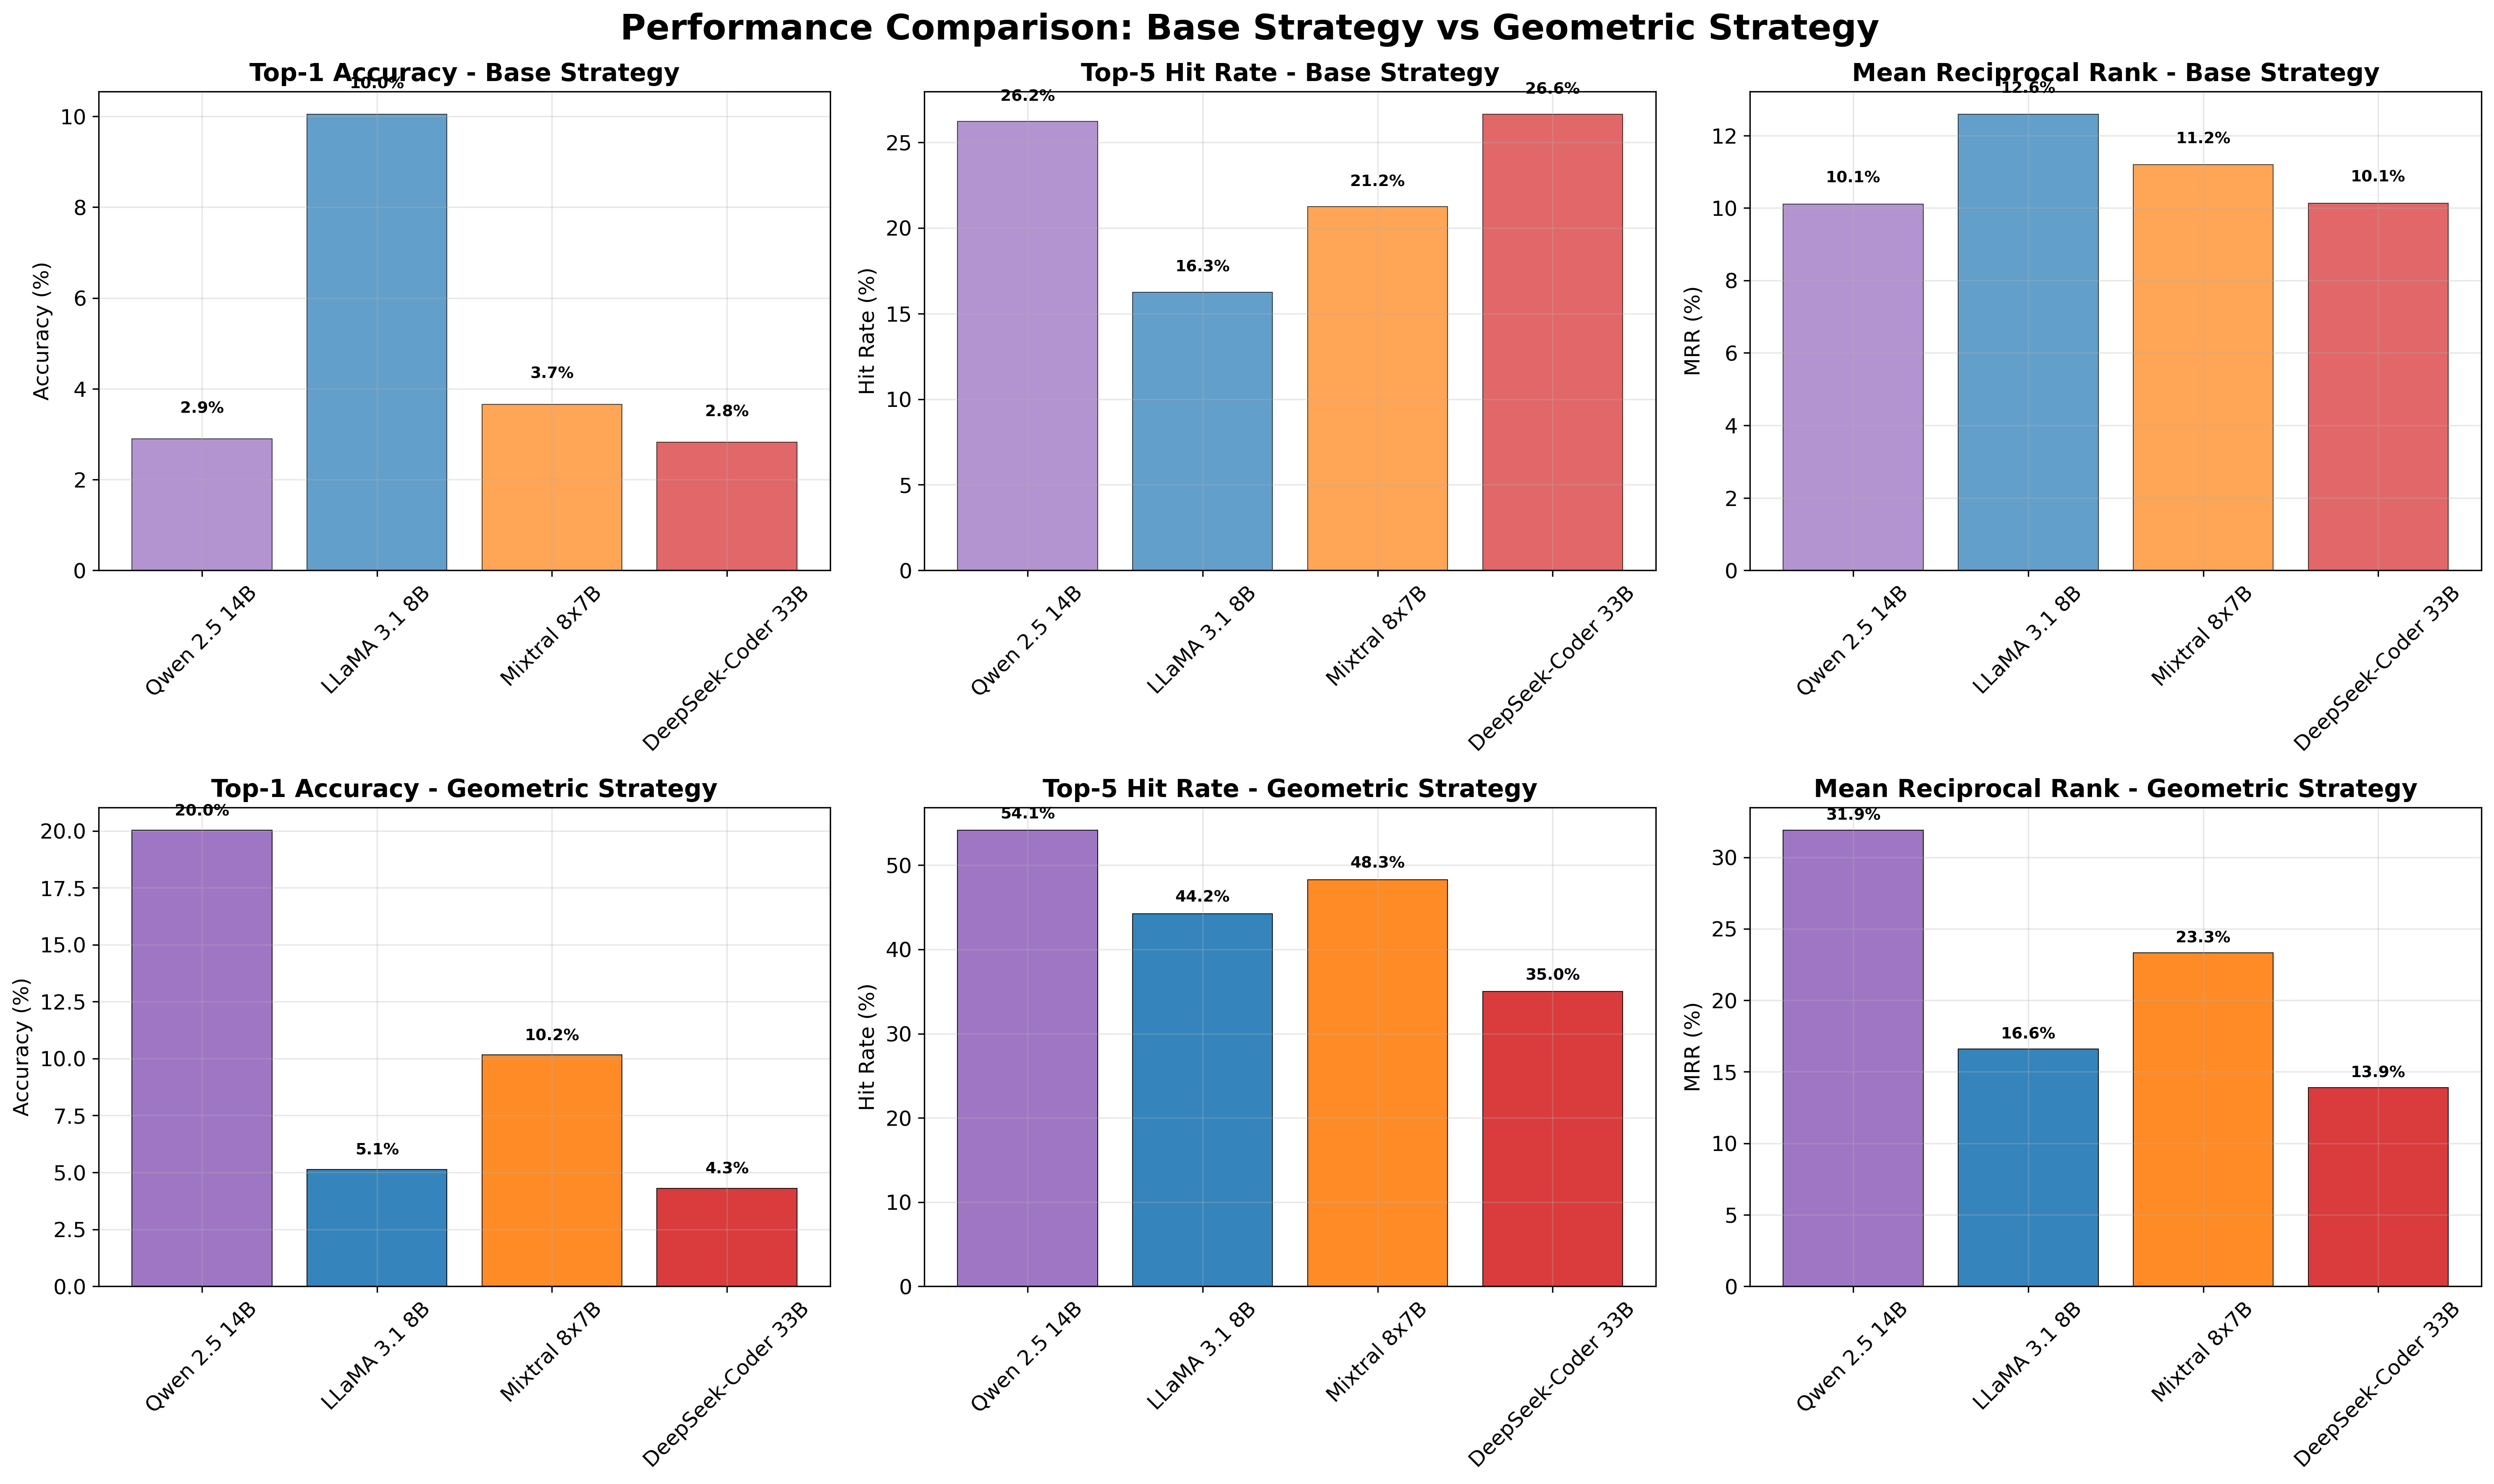


🎨 Creazione grafici sovrapposti per confronto diretto...
💾 Salvato: ../img/multi_model_comparison/side_by_side/top1_base_vs_geom_overlaid.png


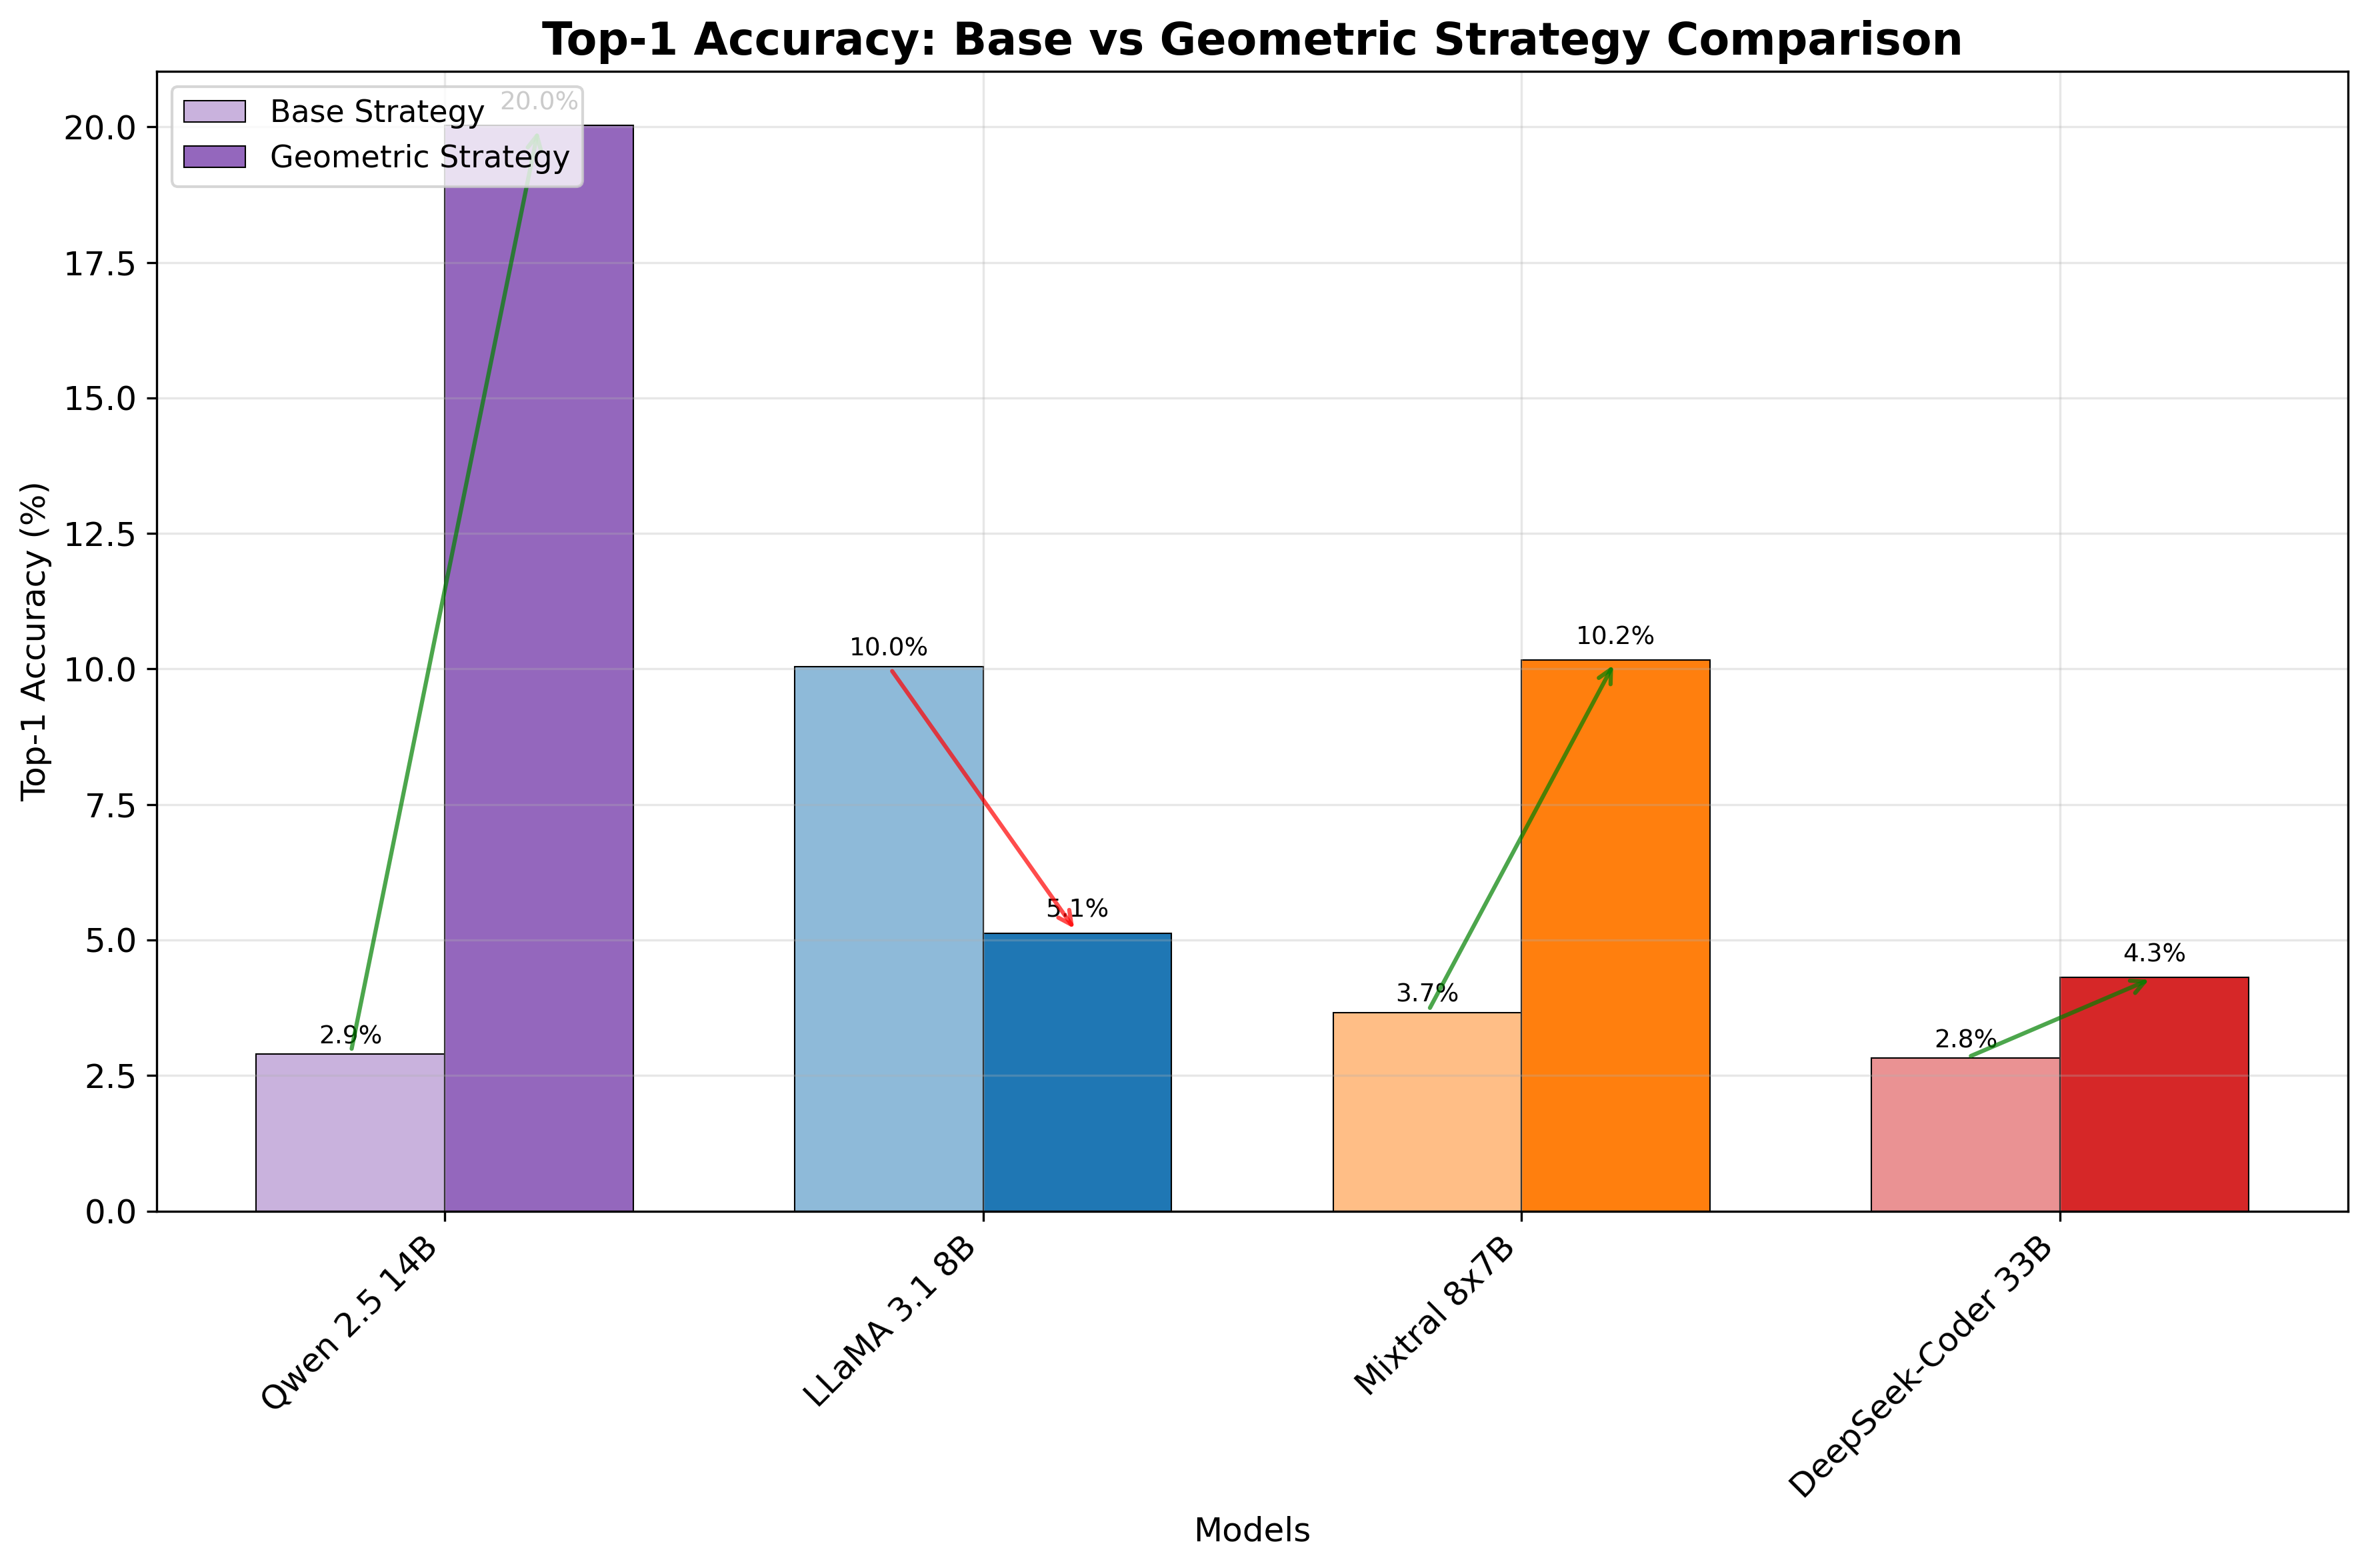

💾 Salvato: ../img/multi_model_comparison/side_by_side/top5_base_vs_geom_overlaid.png


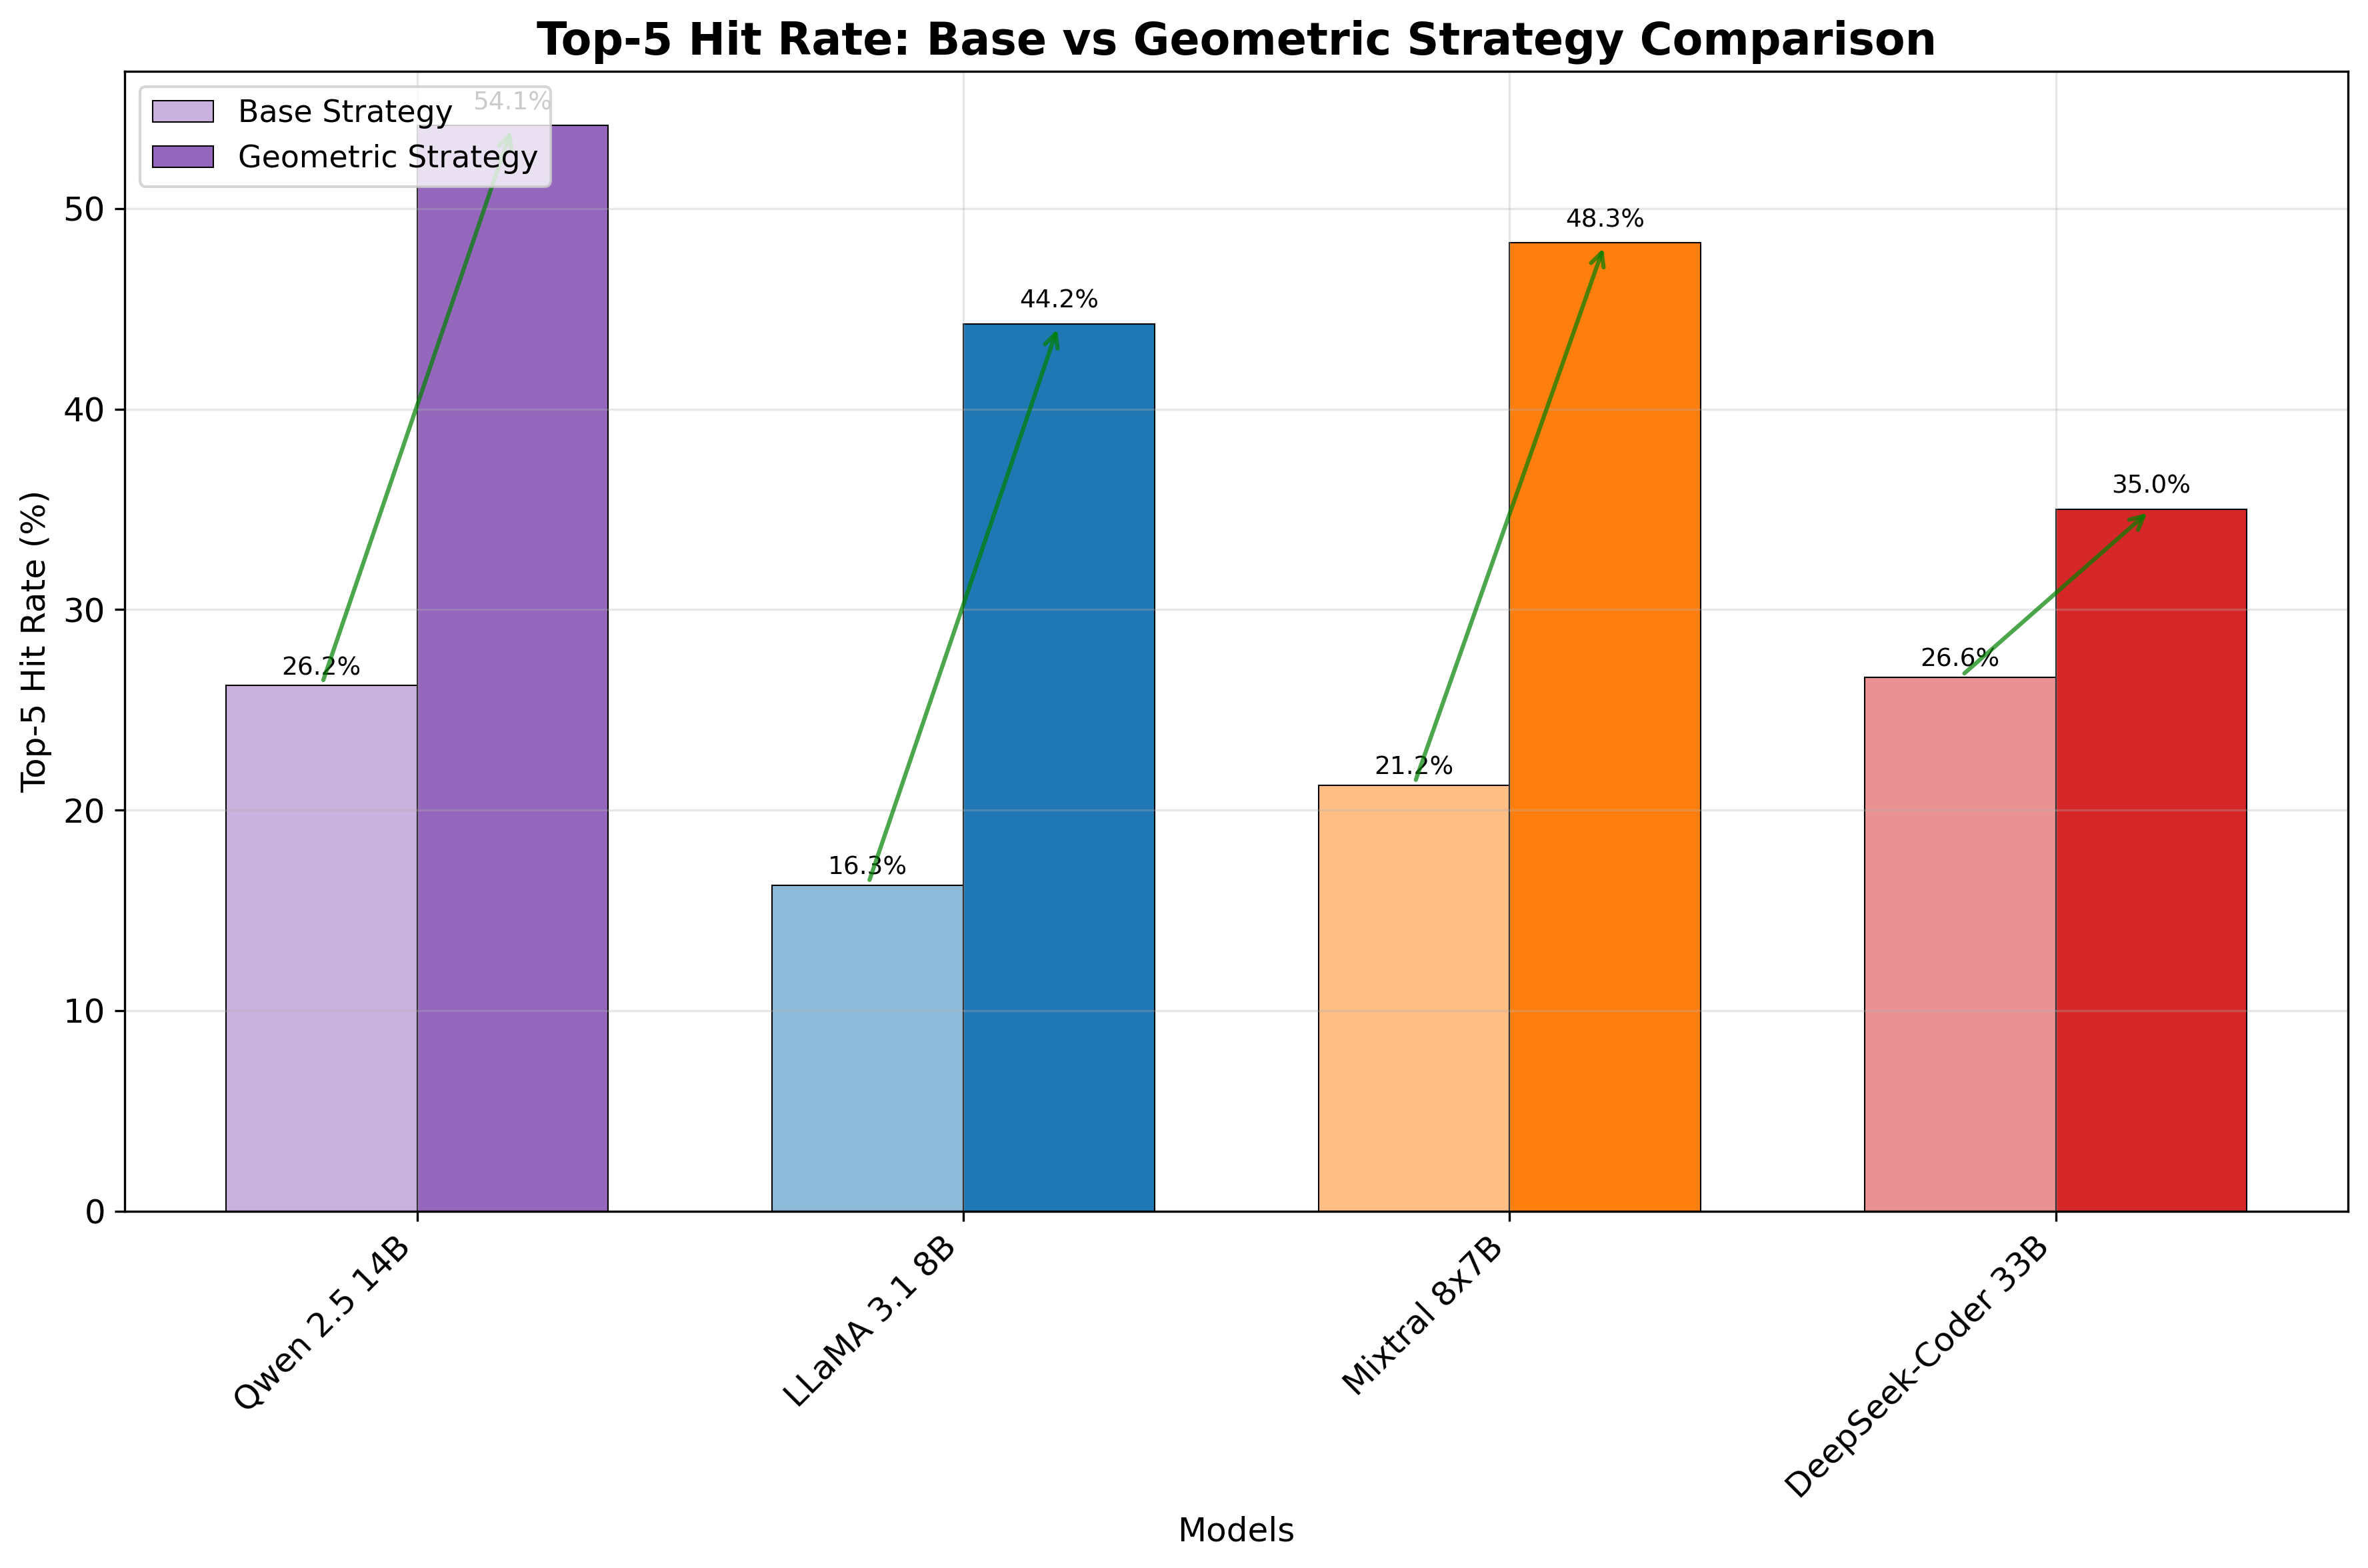

💾 Salvato: ../img/multi_model_comparison/side_by_side/mrr_base_vs_geom_overlaid.png


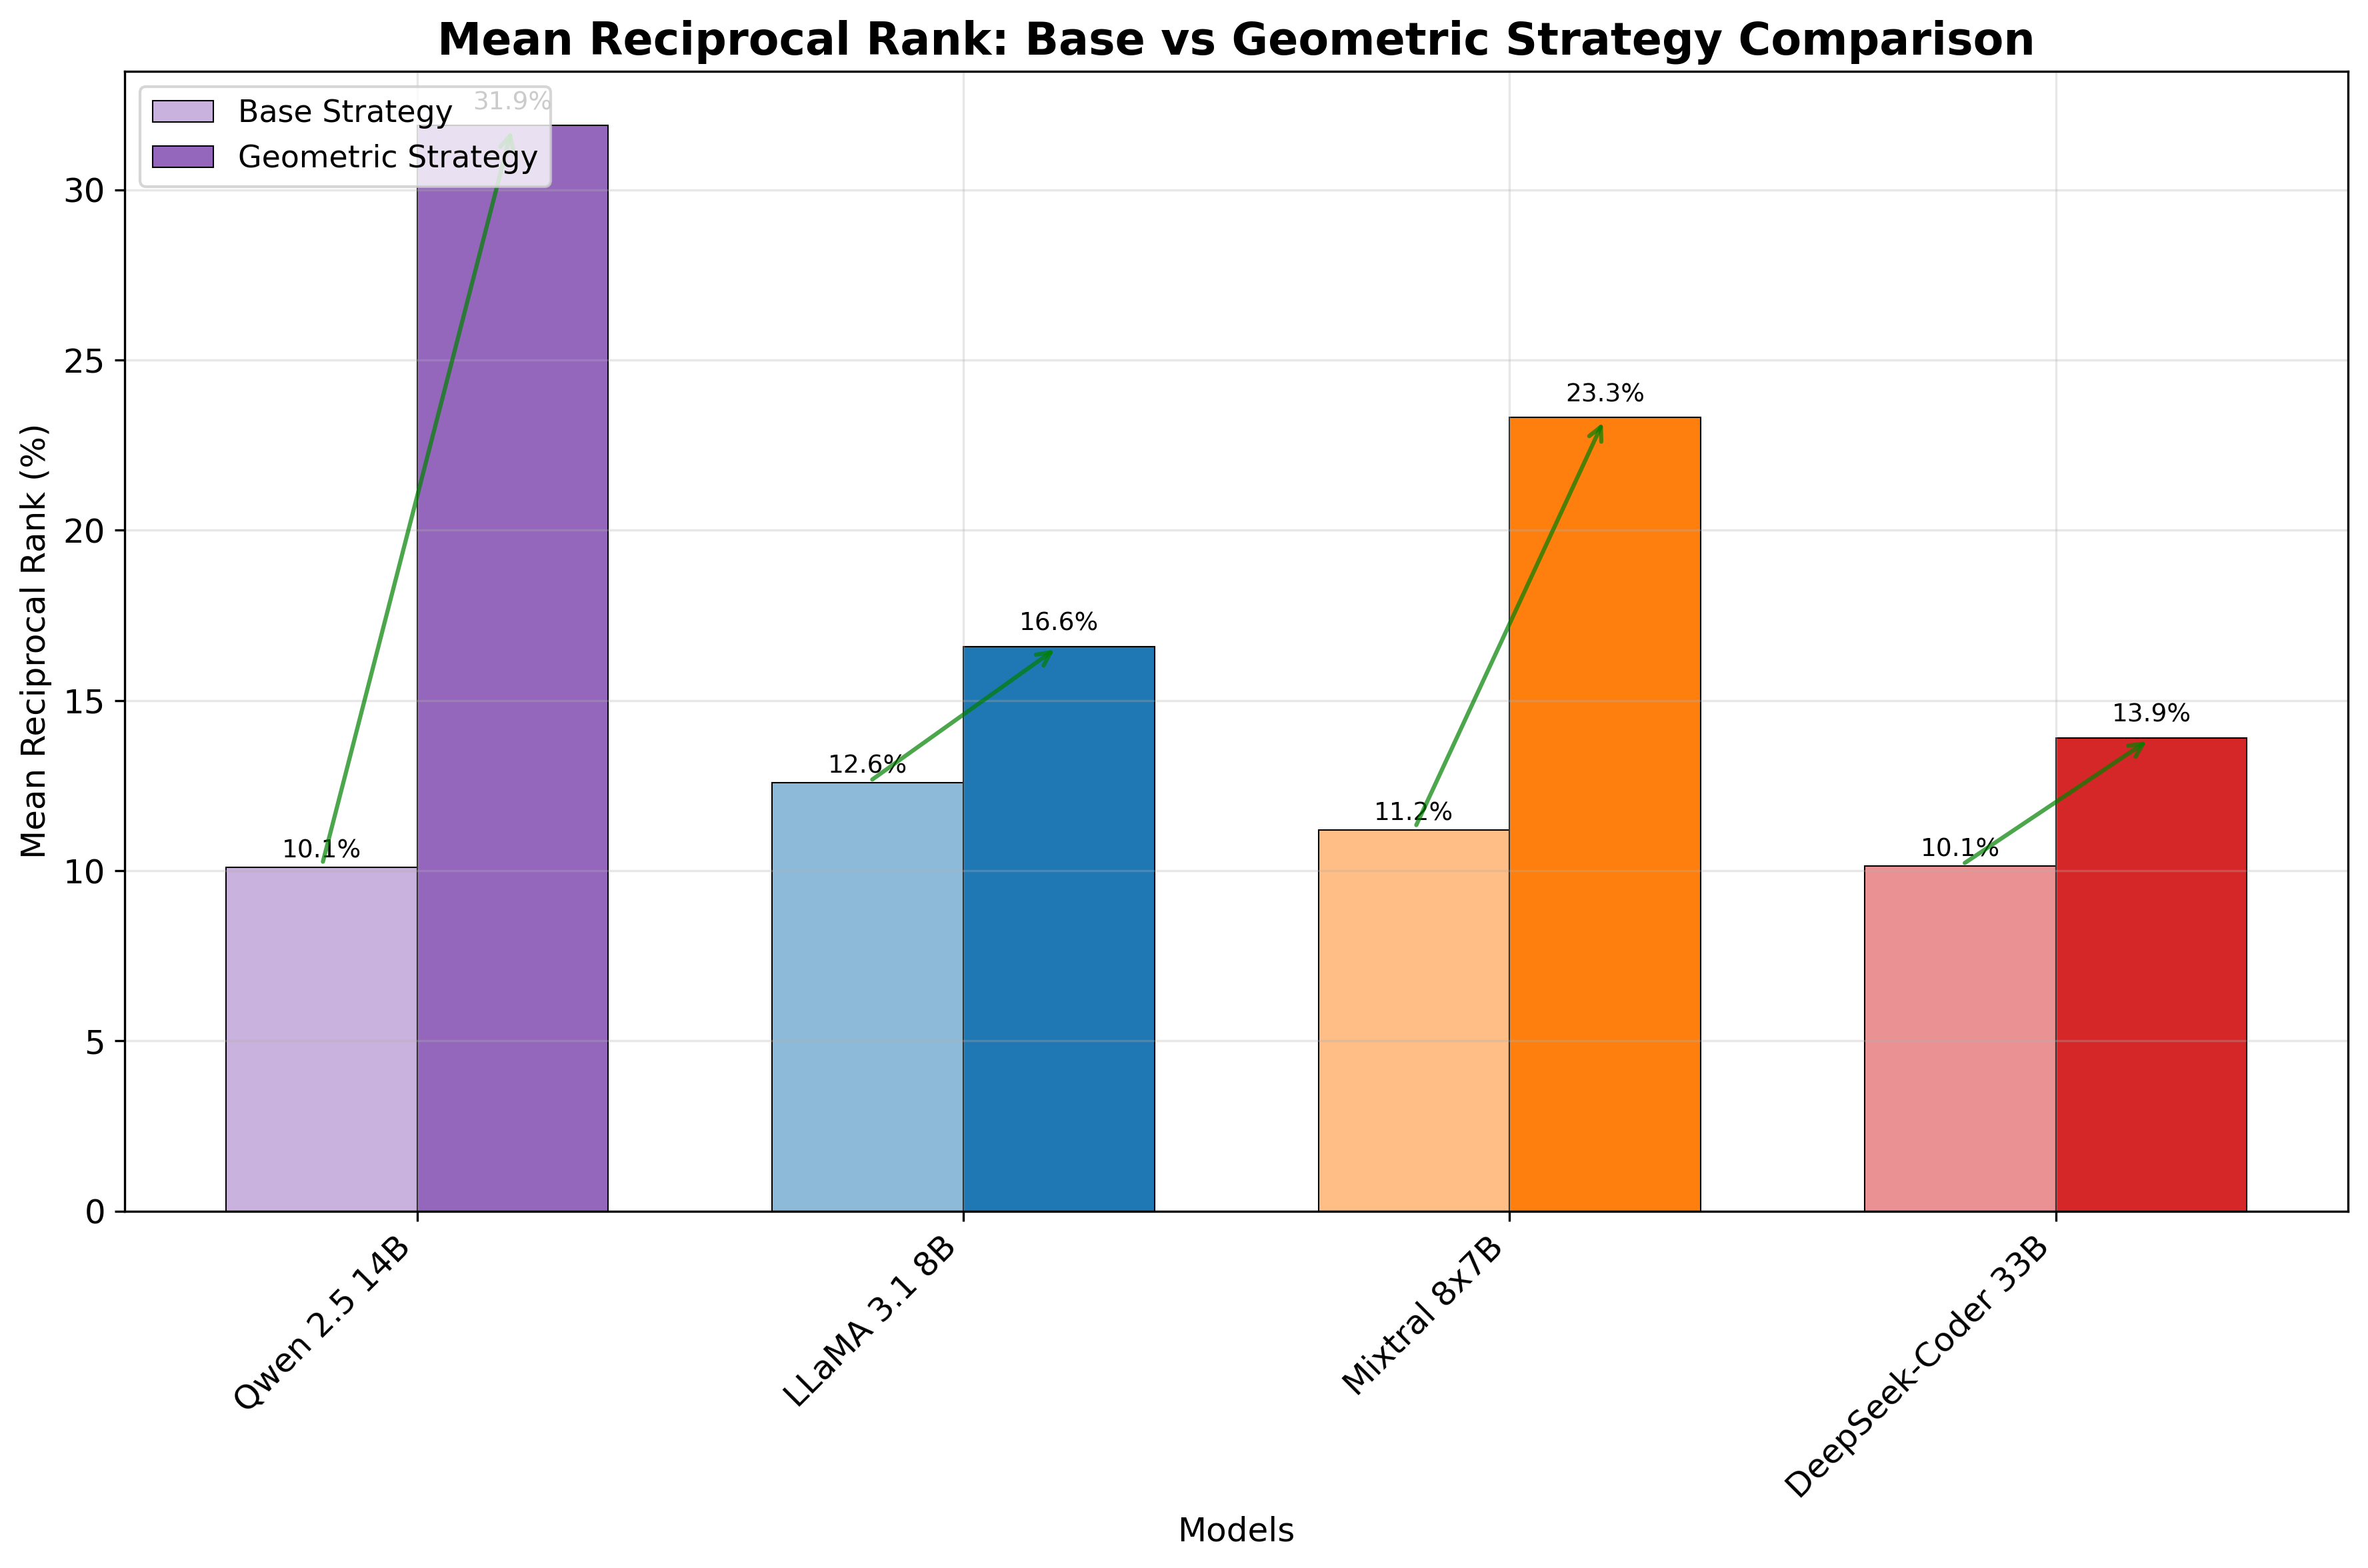

✅ Grafici comparativi affiancati completati!


In [13]:
# ============================================================================
# GRAFICI COMPARATIVI AFFIANCATI - BASE vs GEOM
# ============================================================================

if len(models_both_strategies) < 1:
    print("⏭️  Saltando grafici affiancati: serve almeno 1 modello con entrambe le strategie")
else:
    print("🎨 Creazione grafici comparativi affiancati (Base vs Geom)...")
    
    # Prepara i dati per entrambe le strategie
    models_list = [MODELS[k]['name'] for k in models_both_strategies]
    colors_list = [MODELS[k]['color'] for k in models_both_strategies]
    
    # Metriche per entrambe le strategie
    base_top1 = [model_metrics_base[k]['top1_accuracy'] * 100 for k in models_both_strategies]
    geom_top1 = [model_metrics_geom[k]['top1_accuracy'] * 100 for k in models_both_strategies]
    
    base_top5 = [model_metrics_base[k]['top5_hit_rate'] * 100 for k in models_both_strategies]
    geom_top5 = [model_metrics_geom[k]['top5_hit_rate'] * 100 for k in models_both_strategies]
    
    base_mrr = [model_metrics_base[k]['mrr'] * 100 for k in models_both_strategies]
    geom_mrr = [model_metrics_geom[k]['mrr'] * 100 for k in models_both_strategies]
    
    # ==================== GRAFICO COMPARATIVO PRINCIPALE AFFIANCATO ====================
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Performance Comparison: Base Strategy vs Geometric Strategy', fontsize=20, fontweight='bold')
    
    # RIGA SUPERIORE: Strategia BASE
    # Top-1 Accuracy BASE
    bars1 = axes[0,0].bar(models_list, base_top1, color=colors_list, alpha=0.7, 
                         edgecolor='black', linewidth=0.5, label='Base Strategy')
    axes[0,0].set_title('Top-1 Accuracy - Base Strategy', fontsize=14, fontweight='bold')
    axes[0,0].set_ylabel('Accuracy (%)', fontsize=12)
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].grid(True, alpha=0.3, axis='y')
    
    for bar, value in zip(bars1, base_top1):
        axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                      f'{value:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # Top-5 Hit Rate BASE
    bars2 = axes[0,1].bar(models_list, base_top5, color=colors_list, alpha=0.7, 
                         edgecolor='black', linewidth=0.5, label='Base Strategy')
    axes[0,1].set_title('Top-5 Hit Rate - Base Strategy', fontsize=14, fontweight='bold')
    axes[0,1].set_ylabel('Hit Rate (%)', fontsize=12)
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].grid(True, alpha=0.3, axis='y')
    
    for bar, value in zip(bars2, base_top5):
        axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                      f'{value:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # MRR BASE
    bars3 = axes[0,2].bar(models_list, base_mrr, color=colors_list, alpha=0.7, 
                         edgecolor='black', linewidth=0.5, label='Base Strategy')
    axes[0,2].set_title('Mean Reciprocal Rank - Base Strategy', fontsize=14, fontweight='bold')
    axes[0,2].set_ylabel('MRR (%)', fontsize=12)
    axes[0,2].tick_params(axis='x', rotation=45)
    axes[0,2].grid(True, alpha=0.3, axis='y')
    
    for bar, value in zip(bars3, base_mrr):
        axes[0,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                      f'{value:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # RIGA INFERIORE: Strategia GEOM
    # Top-1 Accuracy GEOM
    bars4 = axes[1,0].bar(models_list, geom_top1, color=colors_list, alpha=0.9, 
                         edgecolor='black', linewidth=0.5, label='Geometric Strategy')
    axes[1,0].set_title('Top-1 Accuracy - Geometric Strategy', fontsize=14, fontweight='bold')
    axes[1,0].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].grid(True, alpha=0.3, axis='y')
    
    for bar, value in zip(bars4, geom_top1):
        axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                      f'{value:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # Top-5 Hit Rate GEOM
    bars5 = axes[1,1].bar(models_list, geom_top5, color=colors_list, alpha=0.9, 
                         edgecolor='black', linewidth=0.5, label='Geometric Strategy')
    axes[1,1].set_title('Top-5 Hit Rate - Geometric Strategy', fontsize=14, fontweight='bold')
    axes[1,1].set_ylabel('Hit Rate (%)', fontsize=12)
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].grid(True, alpha=0.3, axis='y')
    
    for bar, value in zip(bars5, geom_top5):
        axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                      f'{value:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # MRR GEOM
    bars6 = axes[1,2].bar(models_list, geom_mrr, color=colors_list, alpha=0.9, 
                         edgecolor='black', linewidth=0.5, label='Geometric Strategy')
    axes[1,2].set_title('Mean Reciprocal Rank - Geometric Strategy', fontsize=14, fontweight='bold')
    axes[1,2].set_ylabel('MRR (%)', fontsize=12)
    axes[1,2].tick_params(axis='x', rotation=45)
    axes[1,2].grid(True, alpha=0.3, axis='y')
    
    for bar, value in zip(bars6, geom_mrr):
        axes[1,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                      f'{value:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # Aggiungi linee divisorie visive
    for ax in axes.flat:
        ax.set_ylim(bottom=0)
    
    plt.tight_layout()
    
    # Salva il grafico
    output_path = Path(OUTPUT_DIRS['side_by_side']) / 'base_vs_geom_comparison.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"💾 Salvato: {output_path}")
    
    plt.show()
    
    # ==================== GRAFICI SOVRAPPOSTI PER CONFRONTO DIRETTO ====================
    print("\n🎨 Creazione grafici sovrapposti per confronto diretto...")
    
    metrics_info = [
        ('Top-1 Accuracy', base_top1, geom_top1, 'top1_base_vs_geom_overlaid.png'),
        ('Top-5 Hit Rate', base_top5, geom_top5, 'top5_base_vs_geom_overlaid.png'),
        ('Mean Reciprocal Rank', base_mrr, geom_mrr, 'mrr_base_vs_geom_overlaid.png')
    ]
    
    x = np.arange(len(models_list))
    width = 0.35
    
    for metric_name, base_values, geom_values, filename in metrics_info:
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Barre affiancate
        bars1 = ax.bar(x - width/2, base_values, width, label='Base Strategy', 
                      color=[c + '80' for c in colors_list], edgecolor='black', linewidth=0.5)
        bars2 = ax.bar(x + width/2, geom_values, width, label='Geometric Strategy', 
                      color=colors_list, edgecolor='black', linewidth=0.5)
        
        ax.set_xlabel('Models', fontsize=12)
        ax.set_ylabel(f'{metric_name} (%)', fontsize=12)
        ax.set_title(f'{metric_name}: Base vs Geometric Strategy Comparison', 
                    fontsize=16, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(models_list, rotation=45, ha='right')
        ax.legend(loc='upper left', fontsize=11)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Aggiungi valori sopra le barre
        for bar, value in zip(bars1, base_values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(base_values)*0.01, 
                   f'{value:.1f}%', ha='center', va='bottom', fontsize=9)
        
        for bar, value in zip(bars2, geom_values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(geom_values)*0.01, 
                   f'{value:.1f}%', ha='center', va='bottom', fontsize=9)
        
        # Aggiungi frecce di miglioramento
        for i, (base_val, geom_val) in enumerate(zip(base_values, geom_values)):
            if geom_val > base_val:
                ax.annotate('', xy=(i + width/2, geom_val), xytext=(i - width/2, base_val),
                          arrowprops=dict(arrowstyle='->', color='green', lw=1.5, alpha=0.7))
            elif geom_val < base_val:
                ax.annotate('', xy=(i + width/2, geom_val), xytext=(i - width/2, base_val),
                          arrowprops=dict(arrowstyle='->', color='red', lw=1.5, alpha=0.7))
        
        plt.tight_layout()
        
        # Salva
        output_path = Path(OUTPUT_DIRS['side_by_side']) / filename
        plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"💾 Salvato: {output_path}")
        
        plt.show()
    
    print("✅ Grafici comparativi affiancati completati!")

### 3.2 Scatter Plot Performance vs Efficienza

📈 Creazione grafici di analisi miglioramenti con strategia geometrica...
💾 Salvato: ../img/multi_model_comparison/side_by_side/geometric_improvements_delta.png


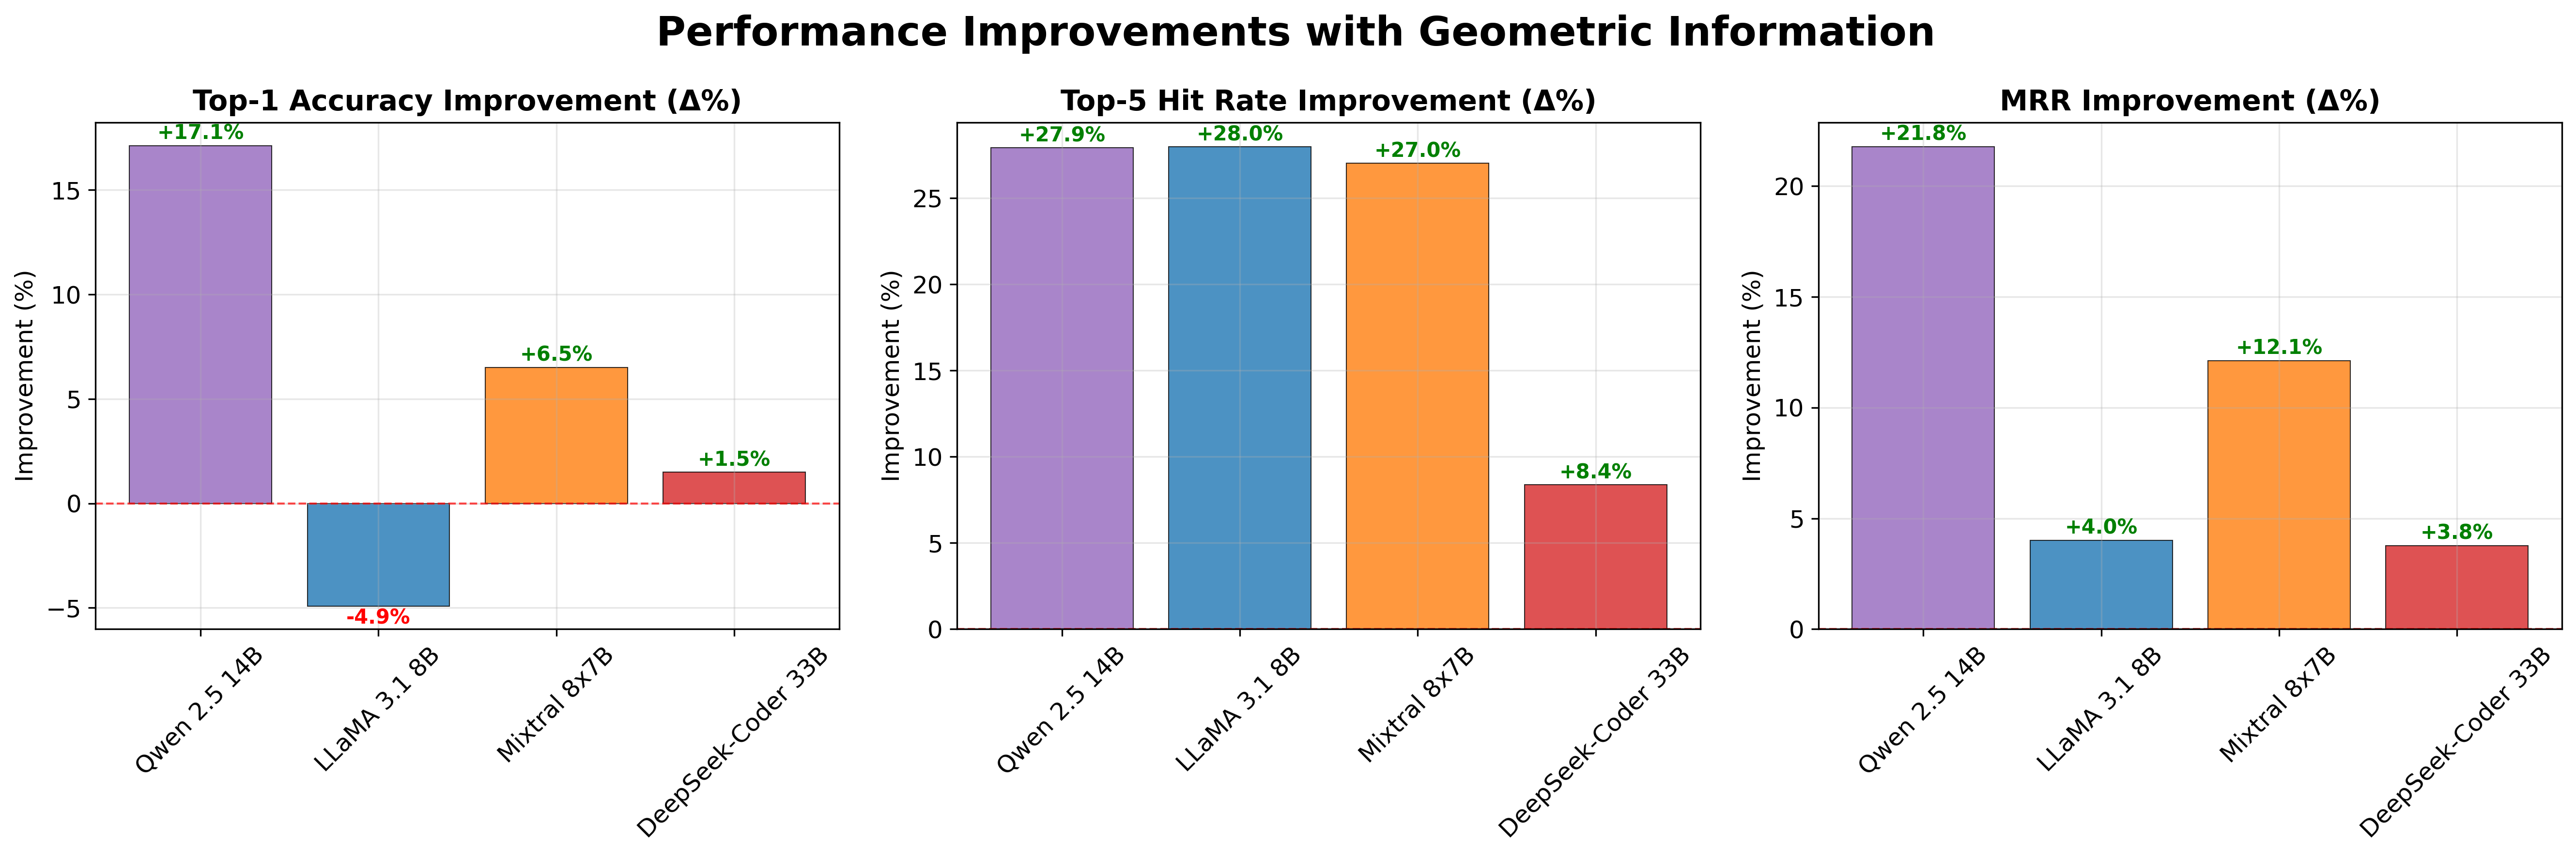


🎨 Creazione radar chart per confronto multi-dimensionale...
💾 Salvato: ../img/multi_model_comparison/side_by_side/radar_chart_base_vs_geom.png


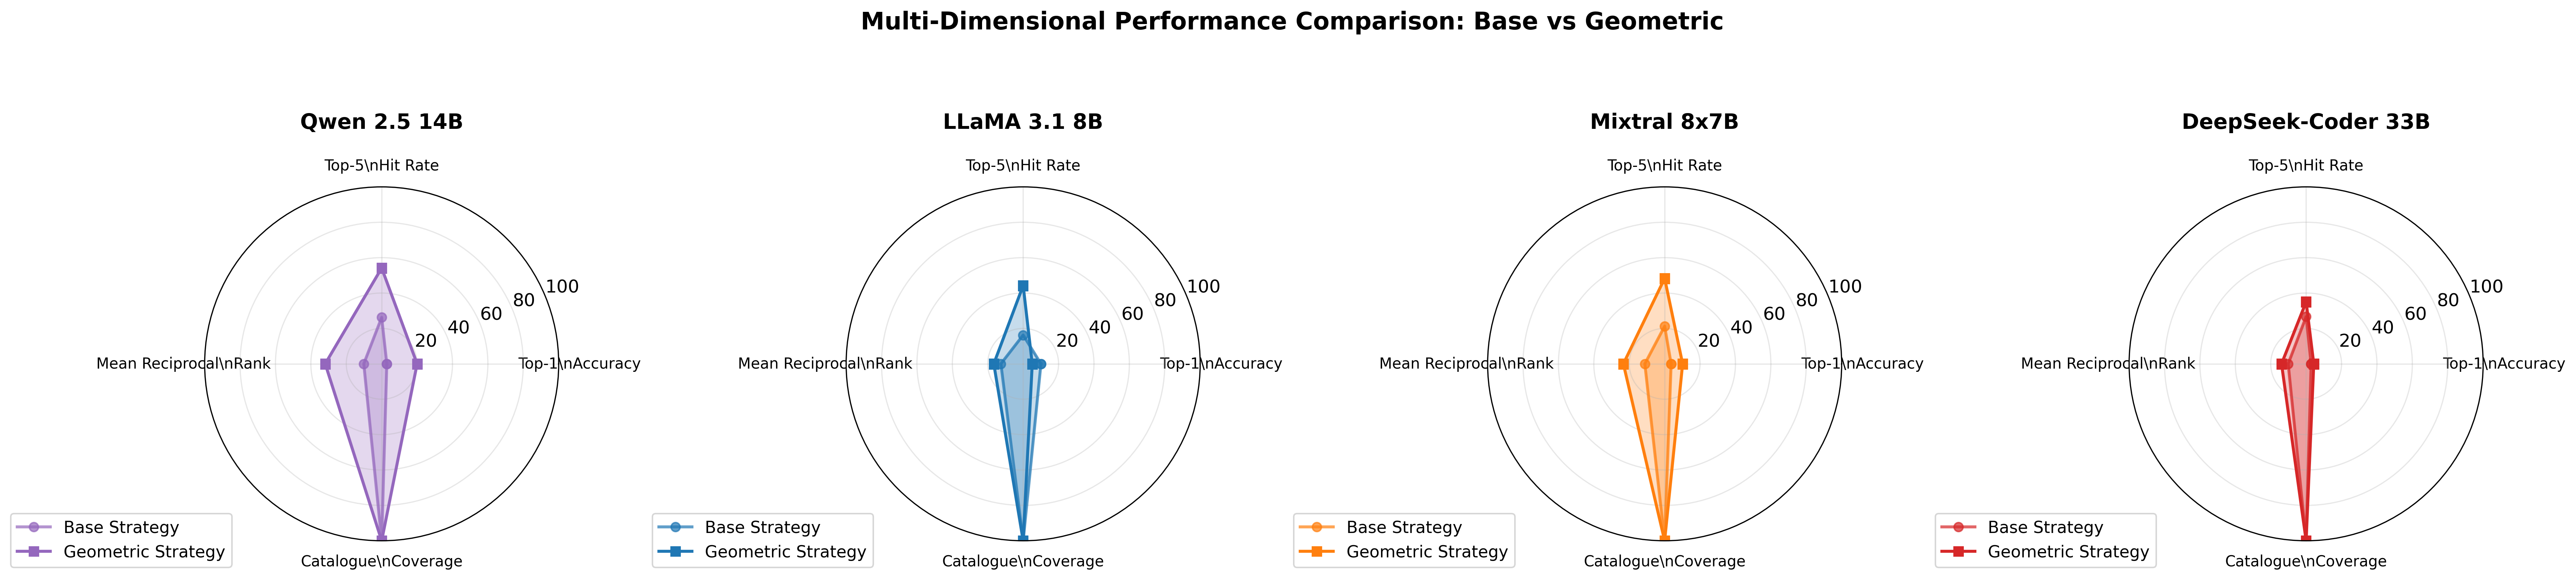


📊 SUMMARY ANALYSIS - Impatto della Strategia Geometrica:
Miglioramenti medi con strategia geometrica:
  📈 Top-1 Accuracy: +5.05% (±8.06%)
  📈 Top-5 Hit Rate: +22.83% (±8.36%)
  📈 MRR:            +10.42% (±7.38%)

Modelli con miglioramenti positivi:
  ✅ Top-1 Accuracy: 3/4 (75.0%)
  ✅ Top-5 Hit Rate: 4/4 (100.0%)
  ✅ MRR:            4/4 (100.0%)

🏆 Modello che beneficia di più dalla strategia geometrica:
   Qwen 2.5 14B
   Top-1: +17.1%, Top-5: +27.9%, MRR: +21.8%

✅ Analisi miglioramenti completata!


In [15]:
# ============================================================================
# GRAFICI DI MIGLIORAMENTO E DELTA ANALYSIS
# ============================================================================

if len(models_both_strategies) < 1:
    print("⏭️  Saltando analisi miglioramenti: serve almeno 1 modello con entrambe le strategie")
else:
    print("📈 Creazione grafici di analisi miglioramenti con strategia geometrica...")
    
    # Calcola i delta per ogni modello
    model_deltas = {}
    for model_key in models_both_strategies:
        base_metrics = model_metrics_base[model_key]
        geom_metrics = model_metrics_geom[model_key]
        
        model_deltas[model_key] = {
            'top1_delta': (geom_metrics['top1_accuracy'] - base_metrics['top1_accuracy']) * 100,
            'top5_delta': (geom_metrics['top5_hit_rate'] - base_metrics['top5_hit_rate']) * 100,
            'mrr_delta': (geom_metrics['mrr'] - base_metrics['mrr']) * 100,
            'coverage_delta': (geom_metrics['catalogue_coverage'] - base_metrics['catalogue_coverage'])
        }
    
    # ==================== GRAFICO DELTA IMPROVEMENTS ====================
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Performance Improvements with Geometric Information', fontsize=20, fontweight='bold')
    
    models_list = [MODELS[k]['name'] for k in models_both_strategies]
    colors_list = [MODELS[k]['color'] for k in models_both_strategies]
    
    # Delta Top-1
    top1_deltas = [model_deltas[k]['top1_delta'] for k in models_both_strategies]
    bars1 = ax1.bar(models_list, top1_deltas, color=colors_list, alpha=0.8, 
                   edgecolor='black', linewidth=0.5)
    ax1.set_title('Top-1 Accuracy Improvement (Δ%)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Improvement (%)', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=1)
    
    for bar, value in zip(bars1, top1_deltas):
        color = 'green' if value > 0 else 'red'
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.1 if value > 0 else -0.1), 
                f'{value:+.1f}%', ha='center', va='bottom' if value > 0 else 'top', 
                fontweight='bold', color=color, fontsize=10)
    
    # Delta Top-5
    top5_deltas = [model_deltas[k]['top5_delta'] for k in models_both_strategies]
    bars2 = ax2.bar(models_list, top5_deltas, color=colors_list, alpha=0.8, 
                   edgecolor='black', linewidth=0.5)
    ax2.set_title('Top-5 Hit Rate Improvement (Δ%)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Improvement (%)', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=1)
    
    for bar, value in zip(bars2, top5_deltas):
        color = 'green' if value > 0 else 'red'
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.1 if value > 0 else -0.1), 
                f'{value:+.1f}%', ha='center', va='bottom' if value > 0 else 'top', 
                fontweight='bold', color=color, fontsize=10)
    
    # Delta MRR
    mrr_deltas = [model_deltas[k]['mrr_delta'] for k in models_both_strategies]
    bars3 = ax3.bar(models_list, mrr_deltas, color=colors_list, alpha=0.8, 
                   edgecolor='black', linewidth=0.5)
    ax3.set_title('MRR Improvement (Δ%)', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Improvement (%)', fontsize=12)
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=1)
    
    for bar, value in zip(bars3, mrr_deltas):
        color = 'green' if value > 0 else 'red'
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.1 if value > 0 else -0.1), 
                f'{value:+.1f}%', ha='center', va='bottom' if value > 0 else 'top', 
                fontweight='bold', color=color, fontsize=10)
    
    plt.tight_layout()
    
    # Salva
    output_path = Path(OUTPUT_DIRS['side_by_side']) / 'geometric_improvements_delta.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"💾 Salvato: {output_path}")
    
    plt.show()
    
    # ==================== RADAR CHART COMPARISON ====================
    print("\n🎨 Creazione radar chart per confronto multi-dimensionale...")
    
    # Prepara dati per radar chart
    metrics_labels = ['Top-1\\nAccuracy', 'Top-5\\nHit Rate', 'Mean Reciprocal\\nRank', 'Catalogue\\nCoverage']
    
    fig, axes = plt.subplots(1, len(models_both_strategies), figsize=(6 * len(models_both_strategies), 6), 
                            subplot_kw=dict(projection='polar'))
    
    if len(models_both_strategies) == 1:
        axes = [axes]  # Assicura che sia sempre una lista
    
    fig.suptitle('Multi-Dimensional Performance Comparison: Base vs Geometric', 
                fontsize=16, fontweight='bold')
    
    for i, model_key in enumerate(models_both_strategies):
        ax = axes[i]
        model_config = MODELS[model_key]
        
        # Dati base e geom normalizzati (0-100)
        base_metrics = model_metrics_base[model_key]
        geom_metrics = model_metrics_geom[model_key]
        
        base_values = [
            base_metrics['top1_accuracy'] * 100,
            base_metrics['top5_hit_rate'] * 100,
            base_metrics['mrr'] * 100,
            min(base_metrics['catalogue_coverage'] * 100, 100)  # Cap at 100%
        ]
        
        geom_values = [
            geom_metrics['top1_accuracy'] * 100,
            geom_metrics['top5_hit_rate'] * 100,
            geom_metrics['mrr'] * 100,
            min(geom_metrics['catalogue_coverage'] * 100, 100)  # Cap at 100%
        ]
        
        # Angoli per il radar chart
        angles = np.linspace(0, 2 * np.pi, len(metrics_labels), endpoint=False).tolist()
        angles += angles[:1]  # Chiude il cerchio
        base_values += base_values[:1]
        geom_values += geom_values[:1]
        
        # Plot
        ax.plot(angles, base_values, 'o-', linewidth=2, label='Base Strategy', 
               color=model_config['color'], alpha=0.7)
        ax.fill(angles, base_values, alpha=0.25, color=model_config['color'])
        
        ax.plot(angles, geom_values, 's-', linewidth=2, label='Geometric Strategy', 
               color=model_config['color'])
        ax.fill(angles, geom_values, alpha=0.25, color=model_config['color'])
        
        # Configurazione
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(metrics_labels, fontsize=10)
        ax.set_ylim(0, 100)
        ax.set_title(f'{model_config["name"]}', fontsize=14, fontweight='bold', pad=20)
        ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
        ax.grid(True)
    
    plt.tight_layout()
    
    # Salva
    output_path = Path(OUTPUT_DIRS['side_by_side']) / 'radar_chart_base_vs_geom.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"💾 Salvato: {output_path}")
    
    plt.show()
    
    # ==================== SUMMARY IMPROVEMENT ANALYSIS ====================
    print("\n📊 SUMMARY ANALYSIS - Impatto della Strategia Geometrica:")
    print("=" * 70)
    
    # Calcola statistiche aggregate
    all_top1_deltas = [model_deltas[k]['top1_delta'] for k in models_both_strategies]
    all_top5_deltas = [model_deltas[k]['top5_delta'] for k in models_both_strategies]
    all_mrr_deltas = [model_deltas[k]['mrr_delta'] for k in models_both_strategies]
    
    print(f"Miglioramenti medi con strategia geometrica:")
    print(f"  📈 Top-1 Accuracy: {np.mean(all_top1_deltas):+.2f}% (±{np.std(all_top1_deltas):.2f}%)")
    print(f"  📈 Top-5 Hit Rate: {np.mean(all_top5_deltas):+.2f}% (±{np.std(all_top5_deltas):.2f}%)")
    print(f"  📈 MRR:            {np.mean(all_mrr_deltas):+.2f}% (±{np.std(all_mrr_deltas):.2f}%)")
    
    # Conteggio miglioramenti positivi
    positive_top1 = sum(1 for d in all_top1_deltas if d > 0)
    positive_top5 = sum(1 for d in all_top5_deltas if d > 0)
    positive_mrr = sum(1 for d in all_mrr_deltas if d > 0)
    
    n_models = len(models_both_strategies)
    print(f"\nModelli con miglioramenti positivi:")
    print(f"  ✅ Top-1 Accuracy: {positive_top1}/{n_models} ({positive_top1/n_models*100:.1f}%)")
    print(f"  ✅ Top-5 Hit Rate: {positive_top5}/{n_models} ({positive_top5/n_models*100:.1f}%)")
    print(f"  ✅ MRR:            {positive_mrr}/{n_models} ({positive_mrr/n_models*100:.1f}%)")
    
    # Modello con maggiori miglioramenti
    best_improvement_model = max(models_both_strategies, 
                               key=lambda k: sum([model_deltas[k]['top1_delta'], 
                                                model_deltas[k]['top5_delta'], 
                                                model_deltas[k]['mrr_delta']]))
    
    print(f"\n🏆 Modello che beneficia di più dalla strategia geometrica:")
    print(f"   {MODELS[best_improvement_model]['name']}")
    best_deltas = model_deltas[best_improvement_model]
    print(f"   Top-1: {best_deltas['top1_delta']:+.1f}%, Top-5: {best_deltas['top5_delta']:+.1f}%, MRR: {best_deltas['mrr_delta']:+.1f}%")
    
    print("\n✅ Analisi miglioramenti completata!")

### 3.3 Heat Map Performance

In [16]:
# ============================================================================
# HEAT MAP PERFORMANCE NORMALIZZATA
# ============================================================================

if len(successfully_loaded) < 2:
    print("⏭️  Saltando heat map: servono almeno 2 modelli")
else:
    print("🎨 Creazione heat map performance normalizzata...")
    
    # Prepara dati per heat map
    metrics_for_heatmap = ['top1_accuracy', 'top5_hit_rate', 'mrr', 'catalogue_coverage']
    metric_labels = ['Top-1\nAccuracy', 'Top-5\nHit Rate', 'Mean Reciprocal\nRank', 'Catalogue\nCoverage']
    
    # Crea matrice dati
    heatmap_data = []
    model_labels = []
    
    for model_key in successfully_loaded:
        model_config = MODELS[model_key]
        metrics = model_metrics[model_key]
        
        row_data = []
        for metric in metrics_for_heatmap:
            if metric == 'catalogue_coverage':
                # Coverage può essere > 1, quindi normalizziamo diversamente
                value = min(metrics[metric] * 100, 100)  # Cap a 100%
            else:
                value = metrics[metric] * 100
            row_data.append(value)
        
        heatmap_data.append(row_data)
        model_labels.append(model_config['name'])
    
    # Converte a numpy array per facilità
    heatmap_matrix = np.array(heatmap_data)
    
    # Crea heat map
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Usa colormap personalizzata
    im = ax.imshow(heatmap_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)
    
    # Configura assi
    ax.set_xticks(range(len(metric_labels)))
    ax.set_xticklabels(metric_labels, rotation=0, ha='center')
    ax.set_yticks(range(len(model_labels)))
    ax.set_yticklabels(model_labels)
    
    # Aggiungi valori nelle celle
    for i in range(len(model_labels)):
        for j in range(len(metric_labels)):
            value = heatmap_matrix[i, j]
            text_color = 'white' if value < 50 else 'black'
            ax.text(j, i, f'{value:.1f}%', ha='center', va='center', 
                   color=text_color, fontweight='bold', fontsize=10)
    
    ax.set_title('Performance Heat Map - Model Comparison\n(Normalized 0-100%)', 
                fontsize=16, fontweight='bold', pad=20)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8, aspect=20)
    cbar.set_label('Performance (%)', rotation=270, labelpad=20, fontsize=12)
    
    plt.tight_layout()
    
    # Salva
    output_path = Path(OUTPUT_DIRS['comparison']) / 'models_performance_heatmap.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"💾 Salvato: {output_path}")
    
    plt.show()
    
    # Analisi best/worst per categoria
    print("\n📊 ANALISI HEAT MAP:")
    print("-" * 40)
    
    for j, metric_name in enumerate(['Top-1 Accuracy', 'Top-5 Hit Rate', 'MRR', 'Coverage']):
        values_for_metric = heatmap_matrix[:, j]
        best_idx = np.argmax(values_for_metric)
        worst_idx = np.argmin(values_for_metric)
        
        print(f"{metric_name}:")
        print(f"  🥇 Best:  {model_labels[best_idx]} ({values_for_metric[best_idx]:.1f}%)")
        print(f"  🥉 Worst: {model_labels[worst_idx]} ({values_for_metric[worst_idx]:.1f}%)")
        print()
    
    print("✅ Heat map performance completata!")

NameError: name 'successfully_loaded' is not defined

## 📈 4. Analisi Temporale Multi-Modello

Confronto delle performance nel tempo per identificare stabilità e trend.

In [ ]:
# ============================================================================
# ANALISI TEMPORALE MULTI-MODELLO
# ============================================================================

if len(successfully_loaded) < 2:
    print("⏭️  Saltando analisi temporale: servono almeno 2 modelli")
else:
    print("📅 Analisi temporale multi-modello...")
    
    # Verifica che abbiamo dati temporali
    temporal_data_available = False
    for model_key in successfully_loaded:
        df = model_data[model_key]
        if 'year' in df.columns and not df['year'].isna().all():
            temporal_data_available = True
            break
    
    if not temporal_data_available:
        print("   ⚠️  Nessun dato temporale disponibile (colonna 'year' mancante o vuota)")
    else:
        print("   ✅ Dati temporali trovati, creazione grafici...")
        
        # Calcola metriche per anno per ogni modello
        temporal_results = {}
        all_years = set()
        
        for model_key in successfully_loaded:
            df = model_data[model_key]
            if 'year' in df.columns:
                # Filtra anni validi
                df_with_year = df[df['year'].notna()]
                
                if len(df_with_year) > 0:
                    # Calcola metriche per anno
                    yearly_metrics = {}
                    for year in df_with_year['year'].unique():
                        year_data = df_with_year[df_with_year['year'] == year]
                        if len(year_data) > 0:
                            metrics = calculate_metrics(year_data)
                            yearly_metrics[int(year)] = metrics
                            all_years.add(int(year))
                    
                    temporal_results[model_key] = yearly_metrics
        
        if len(temporal_results) == 0:
            print("   ⚠️  Nessun risultato temporale calcolabile")
        else:
            # Ordina gli anni
            sorted_years = sorted(all_years)
            print(f"   📊 Anni disponibili: {sorted_years}")
            
            # Crea grafici temporali
            metrics_to_plot = [
                ('top1_accuracy', 'Top-1 Accuracy (%)', 'temporal_top1_comparison.png'),
                ('top5_hit_rate', 'Top-5 Hit Rate (%)', 'temporal_top5_comparison.png'),
                ('mrr', 'Mean Reciprocal Rank (%)', 'temporal_mrr_comparison.png')
            ]
            
            for metric_key, ylabel, filename in metrics_to_plot:
                fig, ax = plt.subplots(figsize=(12, 6))
                
                # Plot linea per ogni modello
                for model_key in successfully_loaded:
                    if model_key in temporal_results:
                        model_config = MODELS[model_key]
                        
                        # Prepara dati per questo modello
                        x_data = []
                        y_data = []
                        
                        for year in sorted_years:
                            if year in temporal_results[model_key]:
                                x_data.append(year)
                                y_data.append(temporal_results[model_key][year][metric_key] * 100)
                        
                        if len(x_data) > 0:
                            ax.plot(x_data, y_data, color=model_config['color'], 
                                   marker='o', linewidth=2, markersize=6,
                                   label=model_config['name'])
                
                ax.set_xlabel('Year', fontsize=12)
                ax.set_ylabel(ylabel, fontsize=12)
                ax.set_title(f'{ylabel.replace(" (%)", "")} - Temporal Comparison', 
                           fontsize=14, fontweight='bold')
                ax.legend(loc='best')
                ax.grid(True, alpha=0.3)
                
                # Evidenzia periodo COVID se presente
                covid_years = [2020, 2021]
                if any(year in sorted_years for year in covid_years):
                    for covid_year in covid_years:
                        if covid_year in sorted_years:
                            ax.axvline(covid_year, color='red', linestyle='--', 
                                     alpha=0.5, linewidth=1)
                    ax.text(0.02, 0.98, 'Red lines: COVID-19 period', 
                           transform=ax.transAxes, fontsize=10, 
                           verticalalignment='top', 
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                
                plt.tight_layout()
                
                # Salva
                output_path = Path(OUTPUT_DIRS['comparison']) / filename
                plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
                print(f"💾 Salvato: {output_path}")
                
                plt.show()
            
            # Analisi di stabilità temporale
            print("\n📊 ANALISI STABILITÀ TEMPORALE:")
            print("-" * 50)
            
            for model_key in successfully_loaded:
                if model_key in temporal_results and len(temporal_results[model_key]) > 1:
                    model_name = MODELS[model_key]['name']
                    
                    # Calcola variabilità per MRR
                    mrr_values = [temporal_results[model_key][year]['mrr'] * 100 
                                 for year in temporal_results[model_key].keys()]
                    mrr_std = np.std(mrr_values)
                    mrr_mean = np.mean(mrr_values)
                    stability_score = mrr_mean / (mrr_std + 1e-6)  # Higher = more stable
                    
                    print(f"{model_name:>15s}: MRR avg={mrr_mean:.1f}%, std={mrr_std:.1f}%, stability={stability_score:.1f}")
            
            print("\n✅ Analisi temporale completata!")

## 🔍 5. Analisi Errori Comparativa

Confronto dei pattern di errore tra i diversi modelli per identificare bias e differenze qualitative.

In [ ]:
# ============================================================================
# ANALISI ERRORI COMPARATIVA
# ============================================================================

if len(successfully_loaded) < 2:
    print("⏭️  Saltando analisi errori: servono almeno 2 modelli")
else:
    print("🔍 Analisi comparativa degli errori...")
    
    # Analizza i POI più problematici per ogni modello
    print("\n📊 POI PIÙ PROBLEMATICI PER MODELLO:")
    print("=" * 60)
    
    model_error_patterns = {}
    
    for model_key in successfully_loaded:
        df = model_data[model_key]
        model_name = MODELS[model_key]['name']
        
        if 'ground_truth_norm' in df.columns and 'prediction_norm' in df.columns:
            # Calcola hit@1 se non presente
            if 'hit@1' not in df.columns:
                df['hit@1'] = df['prediction_norm'].str[0] == df['ground_truth_norm']
            
            # Analizza errori
            errors_df = df[~df['hit@1']].copy()
            
            if len(errors_df) > 0:
                # Top POI problematici (ground truth con più errori)
                error_counts = errors_df['ground_truth_norm'].value_counts().head(5)
                total_counts = df['ground_truth_norm'].value_counts()
                
                print(f"\n🔴 {model_name}:")
                print("   Top POI con più errori:")
                
                error_data = []
                for poi, error_count in error_counts.items():
                    total_count = total_counts.get(poi, error_count)
                    error_rate = error_count / total_count
                    print(f"     {poi[:25]:>25s}: {error_count:>4d} errori ({error_rate:>5.1%})")
                    error_data.append((poi, error_count, error_rate))
                
                model_error_patterns[model_key] = error_data
    
    # Confronto bias geografici
    print(f"\n📊 CONFRONTO BIAS NELLE PREDIZIONI:")
    print("=" * 60)
    
    for model_key in successfully_loaded:
        df = model_data[model_key]
        model_name = MODELS[model_key]['name']
        
        if 'prediction_norm' in df.columns:
            # Analizza predizioni più frequenti (possibili bias)
            all_predictions = []
            for pred_list in df['prediction_norm']:
                if isinstance(pred_list, list) and len(pred_list) > 0:
                    all_predictions.append(pred_list[0])  # Solo top-1 prediction
            
            if all_predictions:
                pred_freq = Counter(all_predictions)
                top_predictions = pred_freq.most_common(5)
                
                print(f"\n🎯 {model_name} - Predizioni più frequenti:")
                total_preds = len(all_predictions)
                for poi, count in top_predictions:
                    percentage = (count / total_preds) * 100
                    print(f"     {poi[:25]:>25s}: {count:>5d} ({percentage:>4.1f}%)")
    
    # Matrice di confusione comparativa (se fattibile)
    if len(successfully_loaded) >= 2:
        print(f"\n📊 Generazione matrici di confusione per confronto...")
        
        # Identifica POI comuni più frequenti
        all_gt_pois = set()
        for model_key in successfully_loaded:
            df = model_data[model_key]
            if 'ground_truth_norm' in df.columns:
                all_gt_pois.update(df['ground_truth_norm'].unique())
        
        # Prendi top 10 POI più comuni
        poi_frequencies = Counter()
        for model_key in successfully_loaded:
            df = model_data[model_key]
            if 'ground_truth_norm' in df.columns:
                poi_frequencies.update(df['ground_truth_norm'].value_counts().to_dict())
        
        top_pois = [poi for poi, _ in poi_frequencies.most_common(10)]
        
        # Crea confusion matrix per ogni modello
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        for i, model_key in enumerate(successfully_loaded):
            if i >= len(axes):
                break
                
            df = model_data[model_key]
            model_name = MODELS[model_key]['name']
            ax = axes[i]
            
            if 'ground_truth_norm' in df.columns and 'prediction_norm' in df.columns:
                # Filtra per top POI
                mask = (df['ground_truth_norm'].isin(top_pois) & 
                       df['prediction_norm'].str[0].isin(top_pois))
                df_filtered = df[mask]
                
                if len(df_filtered) > 0:
                    # Crea confusion matrix
                    cm = pd.crosstab(df_filtered['ground_truth_norm'],
                                   df_filtered['prediction_norm'].str[0],
                                   normalize='index')
                    
                    # Plot heatmap
                    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', 
                              ax=ax, cbar_kws={'shrink': 0.5})
                    ax.set_title(f'{model_name}\nConfusion Matrix', fontweight='bold')
                    ax.set_xlabel('Predicted')
                    ax.set_ylabel('True')
                    
                    # Ruota etichette per leggibilità
                    ax.tick_params(axis='x', rotation=45)
                    ax.tick_params(axis='y', rotation=0)
            else:
                ax.text(0.5, 0.5, f'{model_name}\nDati non disponibili', 
                       ha='center', va='center', transform=ax.transAxes)
        
        # Nascondi assi non utilizzati
        for j in range(len(successfully_loaded), len(axes)):
            axes[j].set_visible(False)
        
        plt.suptitle('Confusion Matrices Comparison - Top 10 POI', 
                    fontsize=16, fontweight='bold')
        plt.tight_layout()
        
        # Salva
        output_path = Path(OUTPUT_DIRS['comparison']) / 'confusion_matrices_comparison.png'
        plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"💾 Salvato: {output_path}")
        
        plt.show()
    
    print("\n✅ Analisi errori comparativa completata!")

## 📋 6. Report Finale e Riepilogo

Genera un report completo con tutti i risultati e le raccomandazioni per l'integrazione nella tesi.

In [ ]:
# ============================================================================
# REPORT FINALE E RIEPILOGO - VERSIONE DOPPIA STRATEGIA
# ============================================================================

print("📋 Generazione report finale (Base + Geometric strategies)...\n")
print("=" * 80)
print("🎓 DUAL-STRATEGY MULTI-MODEL COMPARISON ANALYSIS - FINAL REPORT")
print("=" * 80)

if len(models_both_strategies) == 0:
    print("\n❌ NESSUN MODELLO CON ENTRAMBE LE STRATEGIE - VERIFICA CONFIGURAZIONE")
    print("\n💡 AZIONI RICHIESTE:")
    print("   1. Verifica che esistano le directory:")
    print("      - results_deepseek-coder_33b_base_version/")
    print("      - results_deepseek-coder_33b_with_geom/")  
    print("      - results_mixtr_with_geom/")
    print("      - results/mixtral_8x7b/base_version/")
    print("      - results/qwen2.5_7b/base_version/ e /with_geom/")
    print("      - results/llama3.1_8b/base_version/ e /with_geom_srv_univr/")
    print("   2. Sposta i file CSV nelle directory appropriate")
    print("   3. Ri-esegui questo notebook")
else:
    # Riepilogo modelli con doppia strategia
    print(f"\n📊 MODELLI ANALIZZATI CON DOPPIA STRATEGIA: {len(models_both_strategies)}")
    print("-" * 60)
    
    total_predictions_base = sum(model_metrics_base[k]['total_predictions'] for k in models_both_strategies)
    total_predictions_geom = sum(model_metrics_geom[k]['total_predictions'] for k in models_both_strategies)
    
    for model_key in models_both_strategies:
        model_config = MODELS[model_key]
        metrics_base = model_metrics_base[model_key]
        metrics_geom = model_metrics_geom[model_key]
        
        print(f"✅ {model_config['name']:>20s}:")
        print(f"   Base:     {metrics_base['total_predictions']:>6,} predizioni")
        print(f"   Geom:     {metrics_geom['total_predictions']:>6,} predizioni")
    
    print(f"\n📈 TOTALE PREDIZIONI ANALIZZATE:")
    print(f"   Base Strategy:      {total_predictions_base:,}")
    print(f"   Geometric Strategy: {total_predictions_geom:,}")
    print(f"   GRAN TOTALE:        {total_predictions_base + total_predictions_geom:,}")
    
    # Best performers per strategia
    print(f"\n🏆 BEST PERFORMERS PER STRATEGIA:")
    print("-" * 60)
    
    metrics_names = [
        ('top1_accuracy', 'Top-1 Accuracy'),
        ('top5_hit_rate', 'Top-5 Hit Rate'),
        ('mrr', 'Mean Reciprocal Rank')
    ]
    
    for metric_key, metric_name in metrics_names:
        best_base = max(models_both_strategies, key=lambda k: model_metrics_base[k][metric_key])
        best_geom = max(models_both_strategies, key=lambda k: model_metrics_geom[k][metric_key])
        
        best_base_value = model_metrics_base[best_base][metric_key] * 100
        best_geom_value = model_metrics_geom[best_geom][metric_key] * 100
        
        print(f"{metric_name:>18s}:")
        print(f"   Base: {MODELS[best_base]['name']} ({best_base_value:.1f}%)")
        print(f"   Geom: {MODELS[best_geom]['name']} ({best_geom_value:.1f}%)")
        
        # Evidenzia se stesso modello vince in entrambe
        if best_base == best_geom:
            print(f"   🏆 {MODELS[best_base]['name']} domina entrambe le strategie!")
        print()
    
    # Analisi miglioramenti complessiva
    if 'model_deltas' in locals():
        print(f"\n📈 IMPATTO DELLA STRATEGIA GEOMETRICA:")
        print("-" * 60)
        
        all_top1_deltas = [model_deltas[k]['top1_delta'] for k in models_both_strategies]
        all_top5_deltas = [model_deltas[k]['top5_delta'] for k in models_both_strategies] 
        all_mrr_deltas = [model_deltas[k]['mrr_delta'] for k in models_both_strategies]
        
        print(f"Miglioramenti medi:")
        print(f"   Top-1 Accuracy: {np.mean(all_top1_deltas):+.2f}% ({'✅' if np.mean(all_top1_deltas) > 0 else '❌'})")
        print(f"   Top-5 Hit Rate: {np.mean(all_top5_deltas):+.2f}% ({'✅' if np.mean(all_top5_deltas) > 0 else '❌'})")
        print(f"   MRR:            {np.mean(all_mrr_deltas):+.2f}% ({'✅' if np.mean(all_mrr_deltas) > 0 else '❌'})")
        
        positive_improvements = sum(1 for d in all_top1_deltas + all_top5_deltas + all_mrr_deltas if d > 0)
        total_comparisons = len(all_top1_deltas) * 3
        success_rate = positive_improvements / total_comparisons * 100
        
        print(f"\n🎯 Tasso di successo strategia geometrica: {success_rate:.1f}%")
        print(f"   ({positive_improvements}/{total_comparisons} metriche migliorate)")
    
    # Files generati
    print(f"\n📁 FILES GENERATI:")
    print("-" * 60)
    
    # Controlla tutte le directory di output
    all_generated_files = []
    for output_dir_name, output_dir_path in OUTPUT_DIRS.items():
        dir_path = Path(output_dir_path)
        if dir_path.exists():
            files = list(dir_path.glob('*.png')) + list(dir_path.glob('*.csv')) + list(dir_path.glob('*.tex'))
            all_generated_files.extend(files)
    
    # Raggruppa per tipo
    file_types = {
        'PNG (Grafici)': [f for f in all_generated_files if f.suffix == '.png'],
        'CSV (Tabelle)': [f for f in all_generated_files if f.suffix == '.csv'],
        'TEX (LaTeX)': [f for f in all_generated_files if f.suffix == '.tex']
    }
    
    for file_type, files in file_types.items():
        if files:
            print(f"\n{file_type}:")
            for file_path in sorted(files):
                file_size = file_path.stat().st_size / 1024  # KB
                rel_path = file_path.relative_to(Path.cwd().parent)
                print(f"  ✅ {rel_path} ({file_size:.1f} KB)")
    
    print(f"\n📊 TOTALE FILES GENERATI: {len(all_generated_files)}")
    
    # Istruzioni per LaTeX
    print(f"\n📄 INTEGRAZIONE LATEX AGGIORNATA:")
    print("-" * 60)
    print("1. 📊 Grafici salvati in:")
    print("   - img/multi_model_comparison/side_by_side/ (comparazioni affiancate)")
    print("   - img/multi_model_comparison/base/ (solo strategia base)")
    print("   - img/multi_model_comparison/geom/ (solo strategia geometrica)")
    
    print("2. 📋 Tabelle LaTeX generate:")
    print("   - dual_strategy_table.tex (tabella comparativa completa)")
    print("   - performance_table.tex (se disponibile)")
    
    print("3. 🖼️  Grafici chiave per la tesi:")
    print("   - base_vs_geom_comparison.png (griglia 2x3 affiancata)")
    print("   - top1_base_vs_geom_overlaid.png (confronto diretto Top-1)")
    print("   - geometric_improvements_delta.png (analisi miglioramenti)")
    print("   - radar_chart_base_vs_geom.png (confronto multidimensionale)")
    
    print("4. 📝 Integrazione nel documento:")
    print("   - Usa \\input{img/multi_model_comparison/dual_strategy_table.tex}")
    print("   - \\includegraphics{img/multi_model_comparison/side_by_side/...}")
    
    # Raccomandazioni strategiche
    print(f"\n💡 RACCOMANDAZIONI STRATEGICHE:")
    print("-" * 60)
    
    if len(models_both_strategies) >= 2:
        # Identifica modelli per diversi use case
        most_improved_model = None
        if 'model_deltas' in locals():
            most_improved_model = max(models_both_strategies, 
                                    key=lambda k: sum([model_deltas[k]['top1_delta'], 
                                                     model_deltas[k]['top5_delta'], 
                                                     model_deltas[k]['mrr_delta']]))
        
        best_overall_base = max(models_both_strategies, 
                              key=lambda k: model_metrics_base[k]['top1_accuracy'])
        best_overall_geom = max(models_both_strategies, 
                              key=lambda k: model_metrics_geom[k]['top1_accuracy'])
        
        print(f"🎯 Per massima accuratezza (Base):      {MODELS[best_overall_base]['name']}")
        print(f"🎯 Per massima accuratezza (Geom):      {MODELS[best_overall_geom]['name']}")
        
        if most_improved_model:
            improvement_sum = sum([model_deltas[most_improved_model]['top1_delta'],
                                 model_deltas[most_improved_model]['top5_delta'],
                                 model_deltas[most_improved_model]['mrr_delta']])
            print(f"🚀 Maggior beneficio da geometria:      {MODELS[most_improved_model]['name']} (+{improvement_sum:.1f}%)")
        
        # Analisi cost-benefit se disponibile info sui parametri
        print(f"\n⚖️  TRADE-OFF ANALISI:")
        for model_key in models_both_strategies:
            model_name = MODELS[model_key]['name']
            params = MODELS[model_key]['params']
            base_acc = model_metrics_base[model_key]['top1_accuracy'] * 100
            geom_acc = model_metrics_geom[model_key]['top1_accuracy'] * 100
            
            print(f"  {model_name} ({params}): Base {base_acc:.1f}% → Geom {geom_acc:.1f}%")
    
    # Status completamento
    print(f"\n✅ ANALISI DOPPIA STRATEGIA COMPLETATA CON SUCCESSO!")
    print(f"   📊 {len(models_both_strategies)} modelli analizzati")
    print(f"   🔄 2 strategie di prompt confrontate")
    print(f"   📈 {len(all_generated_files)} file generati")
    print(f"   🎯 Pronto per integrazione nella tesi")

print("\n" + "=" * 80)
print("🎓 DUAL-STRATEGY MULTI-MODEL ANALYSIS COMPLETED")
print("=" * 80)

## 📝 Note Finali e Prossimi Passi - Dual Strategy Analysis

### ✅ Checklist Completamento Dual-Strategy

- [ ] **Auto-detection completata**: Directory rilevate automaticamente per entrambe le strategie
- [ ] **Dati caricati**: Modelli con strategia base E geometrica identificati
- [ ] **Grafici affiancati generati**: Files PNG creati in `img/multi_model_comparison/side_by_side/`
- [ ] **Analisi miglioramenti**: Grafici delta e radar charts completati
- [ ] **Tabelle dual-strategy**: File LaTeX con confronto base vs geom generato

### 🔄 Prossimi Passi per Tesi

1. **📊 Verifica grafici chiave**:
   - `base_vs_geom_comparison.png` - Griglia 2x3 comparativa principale
   - `top1_base_vs_geom_overlaid.png` - Confronto diretto Top-1
   - `geometric_improvements_delta.png` - Analisi miglioramenti
   - `radar_chart_base_vs_geom.png` - Confronto multidimensionale

2. **📋 Integra tabelle LaTeX**: 
   - Copia `dual_strategy_table.tex` nel documento principale
   - Include tabella con `\input{img/multi_model_comparison/dual_strategy_table.tex}`

3. **🖼️ Integra grafici**:
   - Usa path: `\includegraphics{img/multi_model_comparison/side_by_side/...}`
   - I grafici sono ottimizzati per stampa (300 DPI, alta qualità)

4. **📖 Narrativa tesi**: Usa i risultati per supportare:
   - Efficacia delle informazioni geometriche
   - Differenze tra modelli nell'utilizzo del contesto spaziale
   - Trade-off accuratezza vs complessità

### 🔍 Troubleshooting Struttura Ibrida

- **Directory miste**: Configurazione automatica gestisce sia `results/{model}/` che directory separate
- **DeepSeek**: Usa `results_deepseek-coder_33b_*` (directory separate)
- **Mixtral geom**: Usa `results_mixtr_with_geom/` (directory separata)
- **Altri modelli**: Seguono struttura standard `results/{model}/{strategy}/`

### ⚠️ Troubleshooting Dual-Strategy

- **Nessun confronto generato**: Controlla che esista almeno 1 modello con ENTRAMBE le strategie
- **Grafici mancanti**: Verifica che directory `img/multi_model_comparison/` sia scrivibile
- **Errori LaTeX**: Path relativi potrebbero necessitare aggiustamento (`../../img/...`)
- **Performance inaspettate**: Alcuni modelli potrebbero non beneficiare dalle info geometriche

### 🎯 Interpretazione Risultati Dual-Strategy

**Miglioramenti positivi** (Δ > 0): Modello beneficia delle informazioni geometriche
**Miglioramenti negativi** (Δ < 0): Strategia base supera quella geometrica  
**Miglioramenti nulli** (Δ ≈ 0): Nessun impatto significativo delle info spaziali

### 📊 Metriche Chiave per la Tesi

1. **Tasso di successo geometrico**: % di metriche migliorate con strategia geometrica
2. **Miglioramento medio**: Media dei Δ% per Top-1, Top-5, MRR
3. **Modello più reattivo**: Quale modello beneficia di più dalle info geometriche
4. **Consistenza miglioramenti**: Deviazione standard dei miglioramenti

---

**🎉 Analisi Dual-Strategy Completata!** 

Ora hai un sistema completo per confrontare l'impatto delle informazioni geometriche sui diversi modelli LLM. I grafici affiancati e l'analisi quantitativa dei miglioramenti forniranno una base solida per le conclusioni della tua tesi sulla mobilità turistica predittiva.